In [1]:
# imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from scipy.stats import norm
import yfinance as yf

np.set_printoptions(precision=4, suppress=True)
plt.rcParams['axes.formatter.useoffset'] = False

# Step 1 - Data collection

The prices of three asset classes (equities (SP500 Index), rates (10 year treasury yield) and crypto (Binance coin)) data were collected and the estimation of HMM are done on them.

In [2]:
start_date = "2018-01-01"
end_date = "2022-12-31"

# Collecting time series for equity index
equities_data = yf.download("^GSPC", start=start_date, end=end_date)["Adj Close"]
equities_data.name = "Price of SP500 index"


# Collecting time series for rates
rates_data = yf.download("^TNX", start=start_date, end=end_date)["Adj Close"]
rates_data.name = "10 year Treasury bond yield"

# Collecting time series for cryptocurrencies
crypto_data = yf.download("BNB-USD", start=start_date, end=end_date)["Adj Close"]
crypto_data.name = "Price of Binance coin"

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Step 2

## a. Data selection

A simple method using the mean of the series as the threshold is used to visualize two regimes present in the series.

In [3]:
def plot_regime(series):
    threshold = np.mean(series)
    regimes = np.where(series < threshold, 1, 0)
    
    plt.figure(figsize=(30, 5))
    plt.plot(series, color="blue")
    plt.fill_between(series.index, series, where=regimes==0, color="orange", alpha=0.3)
    plt.fill_between(series.index, series, where=regimes==1, color="green", alpha=0.3)
    plt.title(f"{series.name}")
    
    plt.show()

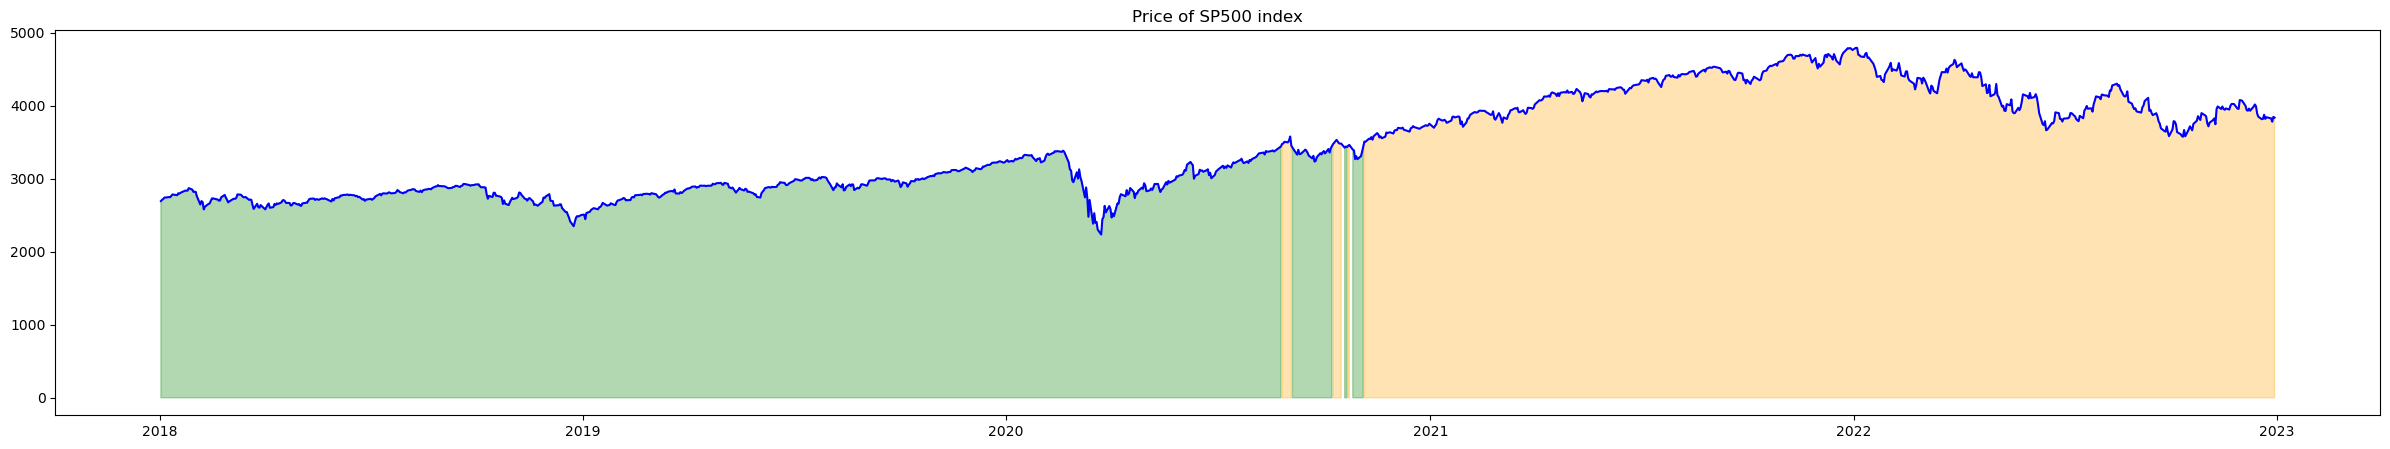

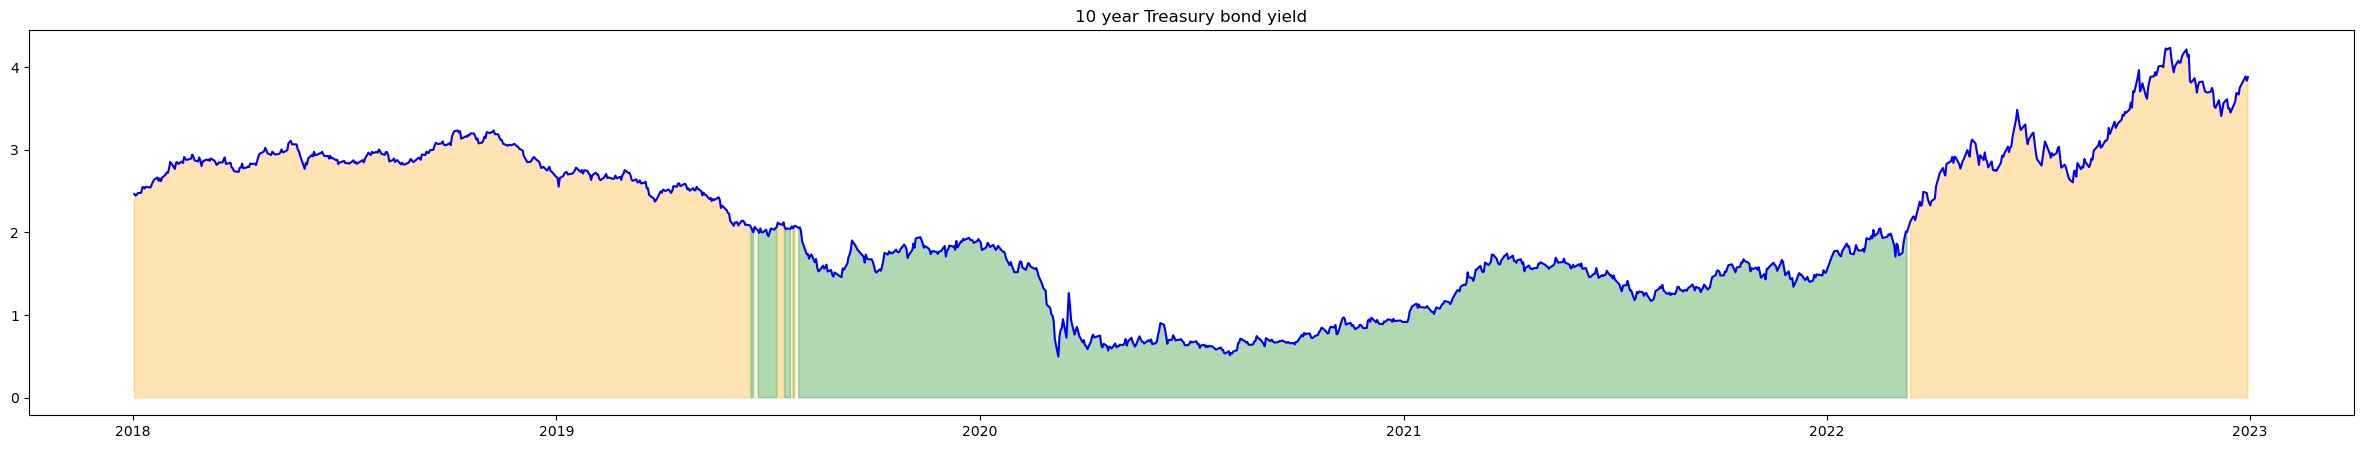

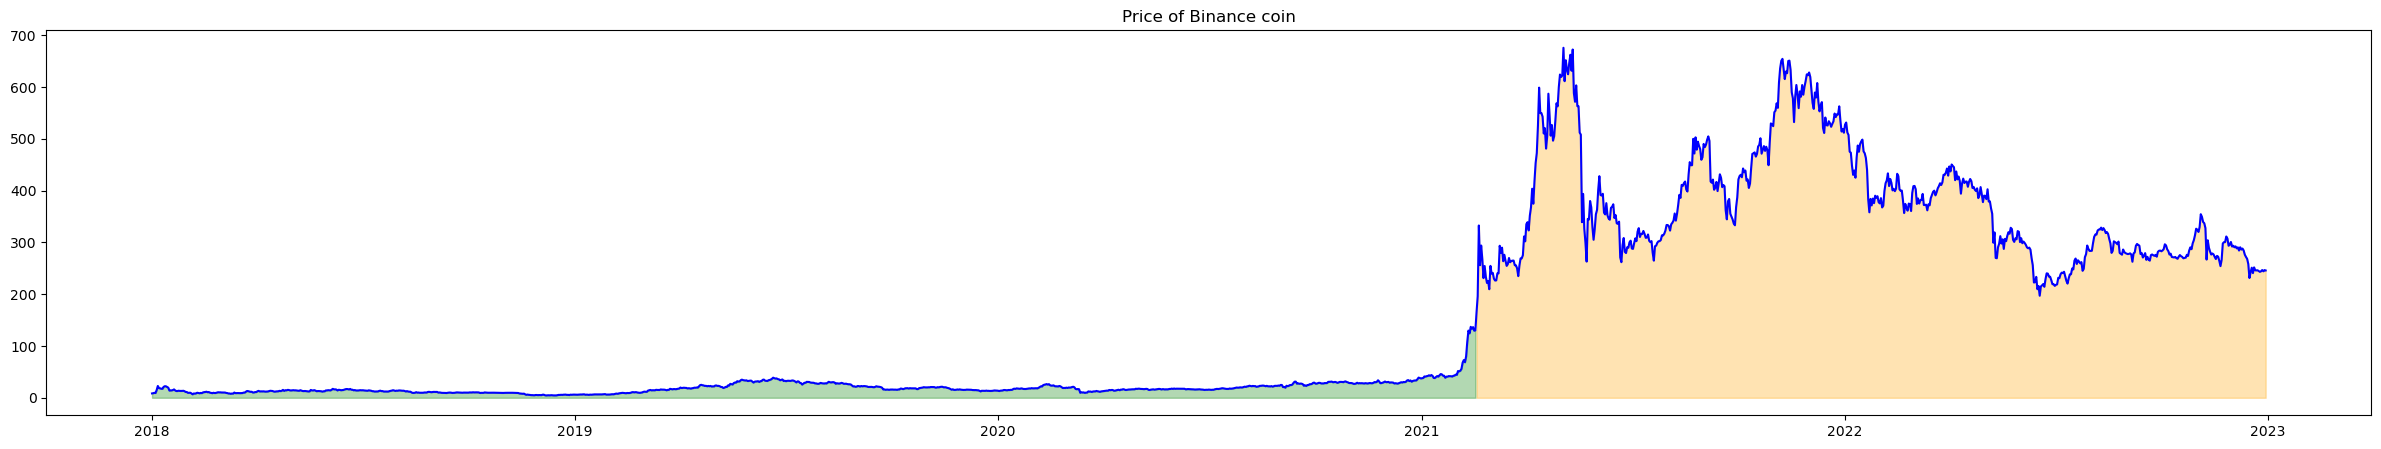

In [4]:
plot_regime(equities_data);
plot_regime(rates_data);
plot_regime(crypto_data);

Of the three assets, we choose Ten-year treasury yield for the study as it has significant regime shifts during the Covid-19 period. We would use the yields at a frequency of 5 days as there will be balance between the amount of information and faster convergance.

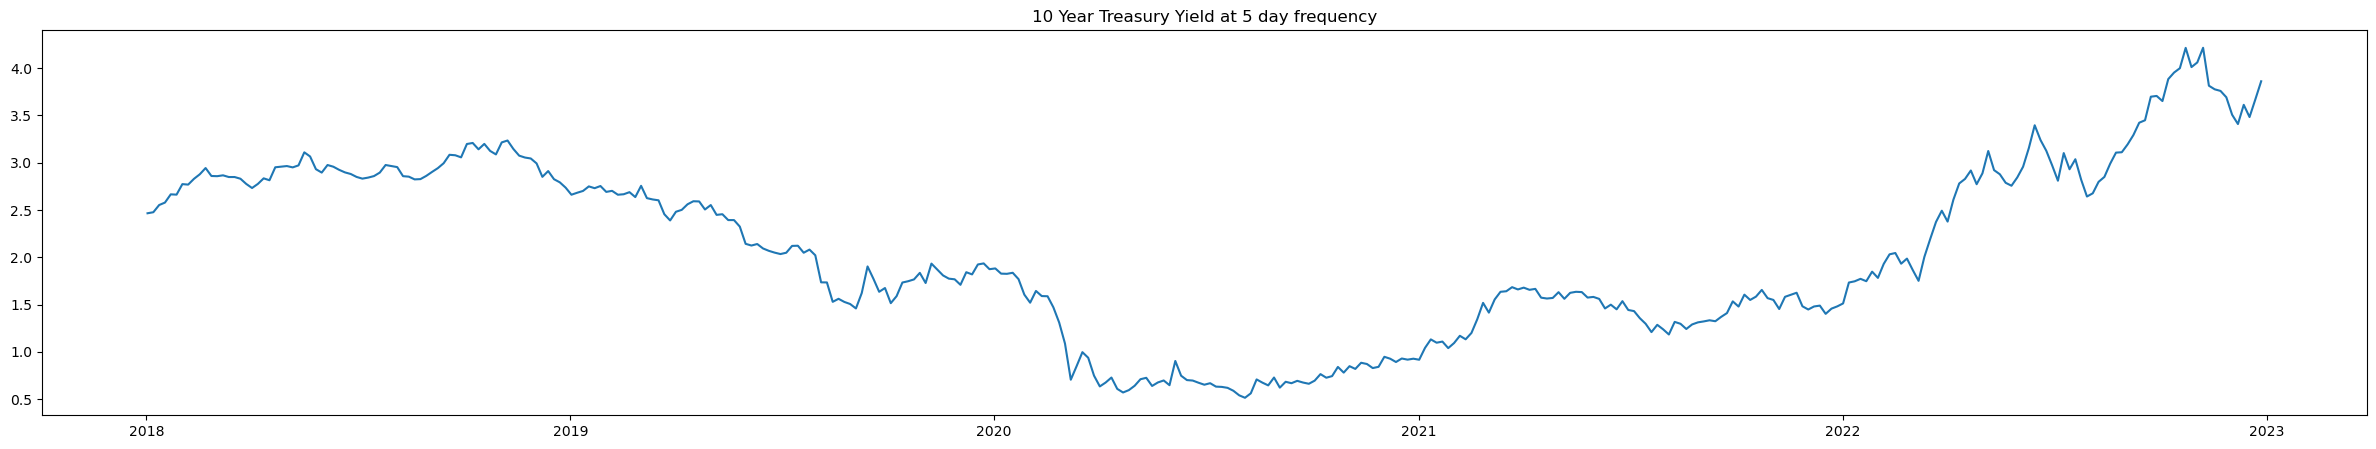

In [5]:
series = rates_data.resample("5D").ffill().dropna()

plt.figure(figsize=(30,5))
plt.plot(series)
plt.title("10 Year Treasury Yield at 5 day frequency");

## b. Markov-regime switching model

The Markov-regime switching model or the Hidden Markov Model (HMM) is used to model the system's unobserved states using the Forward-Backward algorithm. The below code provides the functions for computing the likelihood of an observation, the Hamilton filtering using the Forward algorithm, Kim filtering using the Backward algorithm and three M-step functions used to estimate the model parameters. The M-step functions differ in how they estimate the mean and variance parameters when mean is fixed, variance is fixed and both different.

In [6]:
def likelihood(xi_prob, mu, sigma, y):
    """Likelihood of an observation."""
    phi = norm.pdf((y - mu) / sigma)
    y_like = np.dot(xi_prob, phi)

    return y_like


def forward_alg(pi_hat0, N, T, P, mu, sigma, Y):
    """Hamilton filtering."""
    xi_prob_t = np.zeros((T, N))
    xi_prob_t1 = np.zeros((T, N)) 

    # Case t=1
    y_like = likelihood(pi_hat0, mu, sigma, Y[0])
    for ss in range(0, N):
        phi = np.zeros((N))
        for ss2 in range(0, N):
            phi[ss2] = norm.pdf((Y[0] - mu[ss2]) / sigma[ss2])
    xi_prob_t[0, :] = np.multiply(pi_hat0, phi) / y_like
    for ss in range(0, N):
        xi_prob_t1[0, ss] = np.dot(P[:, ss], xi_prob_t[0, :])

    for tt in range(1, T):
        y_like = likelihood(xi_prob_t1[tt - 1, :], mu, sigma, Y[tt])
        for ss in range(0, N):
            phi = np.zeros((N))
            for ss2 in range(0, N):
                phi[ss2] = norm.pdf((Y[tt] - mu[ss2]) / sigma[ss2])
        xi_prob_t[tt, :] = np.multiply(xi_prob_t1[tt - 1, :], phi) / y_like
        for ss in range(0, N):
            xi_prob_t1[tt, ss] = np.dot(P[:, ss], xi_prob_t[tt, :])

    return xi_prob_t, xi_prob_t1


def backward_alg(xi_prob_t, xi_prob_t1, N, T, P, mu, sigma, Y):
    """Kim filtering."""
    xi_prob_T = np.zeros((T, N))
    xi_prob_T[T - 1, :] = xi_prob_t[T - 1, :]

    for tt in range(T - 2, -1, -1):
        xi_T_xi = np.divide(xi_prob_T[tt + 1, :], xi_prob_t1[tt, :])
        for ss in range(0, N):
            xi_prob_T[tt, ss] = xi_prob_t[tt, ss] * np.dot(P[ss, :], xi_T_xi)

    return xi_prob_T  # , xi_prob_T1


def M_step_func_1(xi_prob, P, N, T, Y):
    """M step function with different mu and sigma."""
    mu_hat = np.zeros((N))
    sigma_hat = np.zeros((N))
    P_hat = np.zeros((N, N))
    pi_hat = np.zeros((N))

    for ss in range(0, N):
        xi_y = np.dot(xi_prob[:, ss], Y)
        mu_hat[ss] = xi_y / np.sum(xi_prob[:, ss])

        xi_y_mu2 = np.dot(xi_prob[:, ss], (Y - mu_hat[ss]) ** 2)
        sigma_hat[ss] = (xi_y_mu2 / np.sum(xi_prob[:, ss])) ** 0.5

        for ss2 in range(0, N):
            P_hat[ss, ss2] = np.sum(P[ss, ss2, 1:]) / np.sum(
                P[ss, :, 1:]
            )

        pi_hat[ss] = xi_prob[0, ss]

    return mu_hat, sigma_hat, P_hat, pi_hat


def M_step_func_2(xi_prob, P, N, T, Y):
    """M step function with different mu and fixed sigma."""
    mu_hat = np.zeros((N))
    sigma_hat = 0
    P_hat = np.zeros((N, N))
    pi_hat = np.zeros((N))

    for ss in range(0, N):
        xi_y = np.dot(xi_prob[:, ss], Y)
        mu_hat[ss] = xi_y / np.sum(xi_prob[:, ss])

        xi_y_mu2 = np.dot(xi_prob[:, ss], (Y - mu_hat[ss]) ** 2)
        sigma_hat += xi_y_mu2

        for ss2 in range(0, N):
            P_hat[ss, ss2] = np.sum(P[ss, ss2, 1:]) / np.sum(
                P[ss, :, 1:]
            )

        pi_hat[ss] = xi_prob[0, ss]

    sigma_hat = np.sqrt(sigma_hat / T)
    sigma_hat = sigma_hat * np.ones((N))

    return mu_hat, sigma_hat, P_hat, pi_hat


def M_step_func_3(xi_prob, P, N, T, Y):
    """M step function with fixed mu and differet sigma."""
    mu_hat = Y.mean()
    sigma_hat = np.zeros((N))
    P_hat = np.zeros((N, N))
    pi_hat = np.zeros((N))

    for ss in range(0, N):
        xi_y_mu2 = np.dot(xi_prob[:, ss], (Y - mu_hat) ** 2)
        sigma_hat[ss] = (xi_y_mu2 / np.sum(xi_prob[:, ss])) ** 0.5

        for ss2 in range(0, N):
            P_hat[ss, ss2] = np.sum(P[ss, ss2, 1:]) / np.sum(
                P[ss, :, 1:]
            )

        pi_hat[ss] = xi_prob[0, ss]

    mu_hat = mu_hat * np.ones((N))
    
    return mu_hat, sigma_hat, P_hat, pi_hat


def markov_regimes(data, N=2, fixed_mu=False, fixed_sigma=False):
    """Estimate the regime parameters."""
    if fixed_mu and fixed_sigma:
        raise ValueError("Can't have both mu and sigma fixed.")

    T = len(data)
    mean = data.mean()
    std = data.std()
    
    # initial guesses
    mu_hat0 = np.linspace(mean - std * N / 2, mean + std * N / 2, num=N)
    sigma_hat0 = np.ones(N) * std
    P_hat0 = np.ones((N, N)) * (1 / N)
    pi_hat0 = np.ones(N) * (1 / N)

    for t in range(1, 100):
        pi_hat0 = np.dot(P_hat0.T, pi_hat0)

    # Determine maximum number of iterations until convergence and convergence tolerance
    itemax = 500
    itetol = 1e-2

    for ite in range(0, itemax):
        # E-step
        xi_prob_t, xi_prob_t1 = forward_alg(pi_hat0, N, T, P_hat0, mu_hat0, sigma_hat0, data)
        xi_prob_T = backward_alg(xi_prob_t, xi_prob_t1, N, T, P_hat0, mu_hat0, sigma_hat0, data)

        # Compute Pr(s_t+1 = j, s_t = i)
        P_hat_T = np.zeros((N, N, T))
        for tt in range(1, T):
            for ss in range(0, N):
                for ss2 in range(0, N):
                    P_hat_T[ss, ss2, tt] = (
                        P_hat0[ss, ss2]
                        * xi_prob_t[tt - 1, ss]
                        * xi_prob_T[tt, ss2]
                        / xi_prob_t1[tt - 1, ss2]
                    )
        # M-step
        m_step = (
            M_step_func_1 if (not fixed_mu and not fixed_sigma)
            else (
                M_step_func_2 if fixed_sigma else M_step_func_3
            )
        )
        mu_hat1, sigma_hat1, P_hat1, pi_hat1 = m_step(
            xi_prob_T, P_hat_T, N, T, data
        )

        diff = np.zeros((4))
        diff[0] = np.sum(np.absolute(mu_hat1 - mu_hat0)) / (np.min(mu_hat0) + itetol * 1e-2)
        diff[1] = np.sum(np.absolute(sigma_hat1 - sigma_hat0)) / (
            np.min(sigma_hat0) + itetol * 1e-2
        )
        diff[2] = np.sum(np.absolute(np.subtract(P_hat1, P_hat0))) / (
            np.min(P_hat0) + itetol * 1e-2
        )
        diff[3] = np.sum(np.absolute(pi_hat1 - pi_hat0)) / (np.min(pi_hat0) + itetol * 1e-2)
        
        y_like = np.zeros(T)
        for tt in range(T):
            y_like[tt] = likelihood(np.concatenate(([pi_hat1], xi_prob_t1[0:T-1]))[tt,:], mu_hat1, sigma_hat1, data[tt])
        
        sum_log_like = np.sum(np.log(y_like))

        if np.max(diff) > itetol:
            mu_hat0, sigma_hat0, P_hat0, pi_hat0 = mu_hat1, sigma_hat1, P_hat1, pi_hat1
        else:
            print(f"Iterations: {ite}, diff: {np.max(diff):.4f}")
            
            fig, ax = plt.subplot_mosaic([list(range(N)),[N]*N], figsize=(25, 10));
            
            for i in range(N):
                ax[i].plot(series.index, xi_prob_T[:, i])
                ax[i].set_ylim([-0.1, 1.1])
                ax[i].set_yticks(np.linspace(0, 1, 5))
                ax[i].xaxis.set_major_locator(mdates.YearLocator())
            
            max_state = np.argmax(xi_prob_T, axis=1)
            ax[N].plot(series)
            
            for i in range(len(series)):
                ax[N].axvline(x=series.index[i], color=plt.cm.Set1(max_state[i]), alpha = 0.3)
                
            plt.show()

            return mu_hat1, sigma_hat1, P_hat1, pi_hat1, sum_log_like

### i. Different number of states

Estimating with 2 states
Iterations: 6, diff: 0.0024


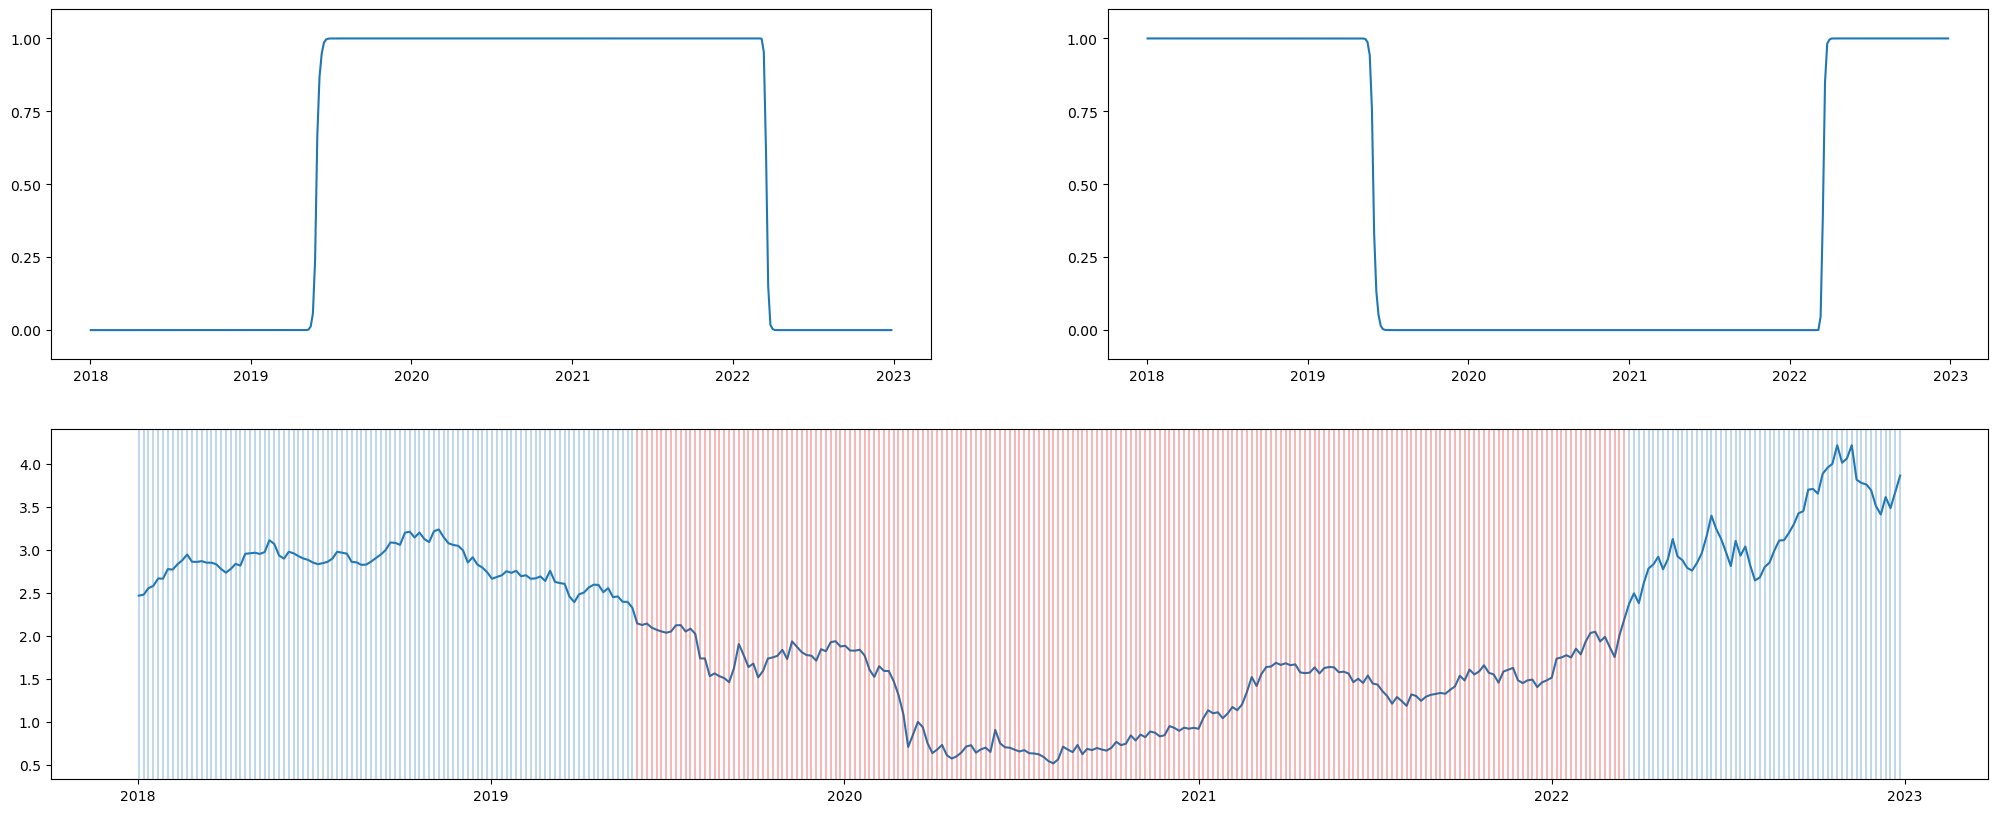

Mean of the states: 
[1.3555 2.9609] 

Standard deviation of the states: 
[0.4674 0.3926] 

Transition Probability Matrix: 
[[0.9951 0.0049]
 [0.0063 0.9937]] 

Intial Probability: 
[0. 1.] 

Estimating with 3 states
Iterations: 24, diff: 0.0094


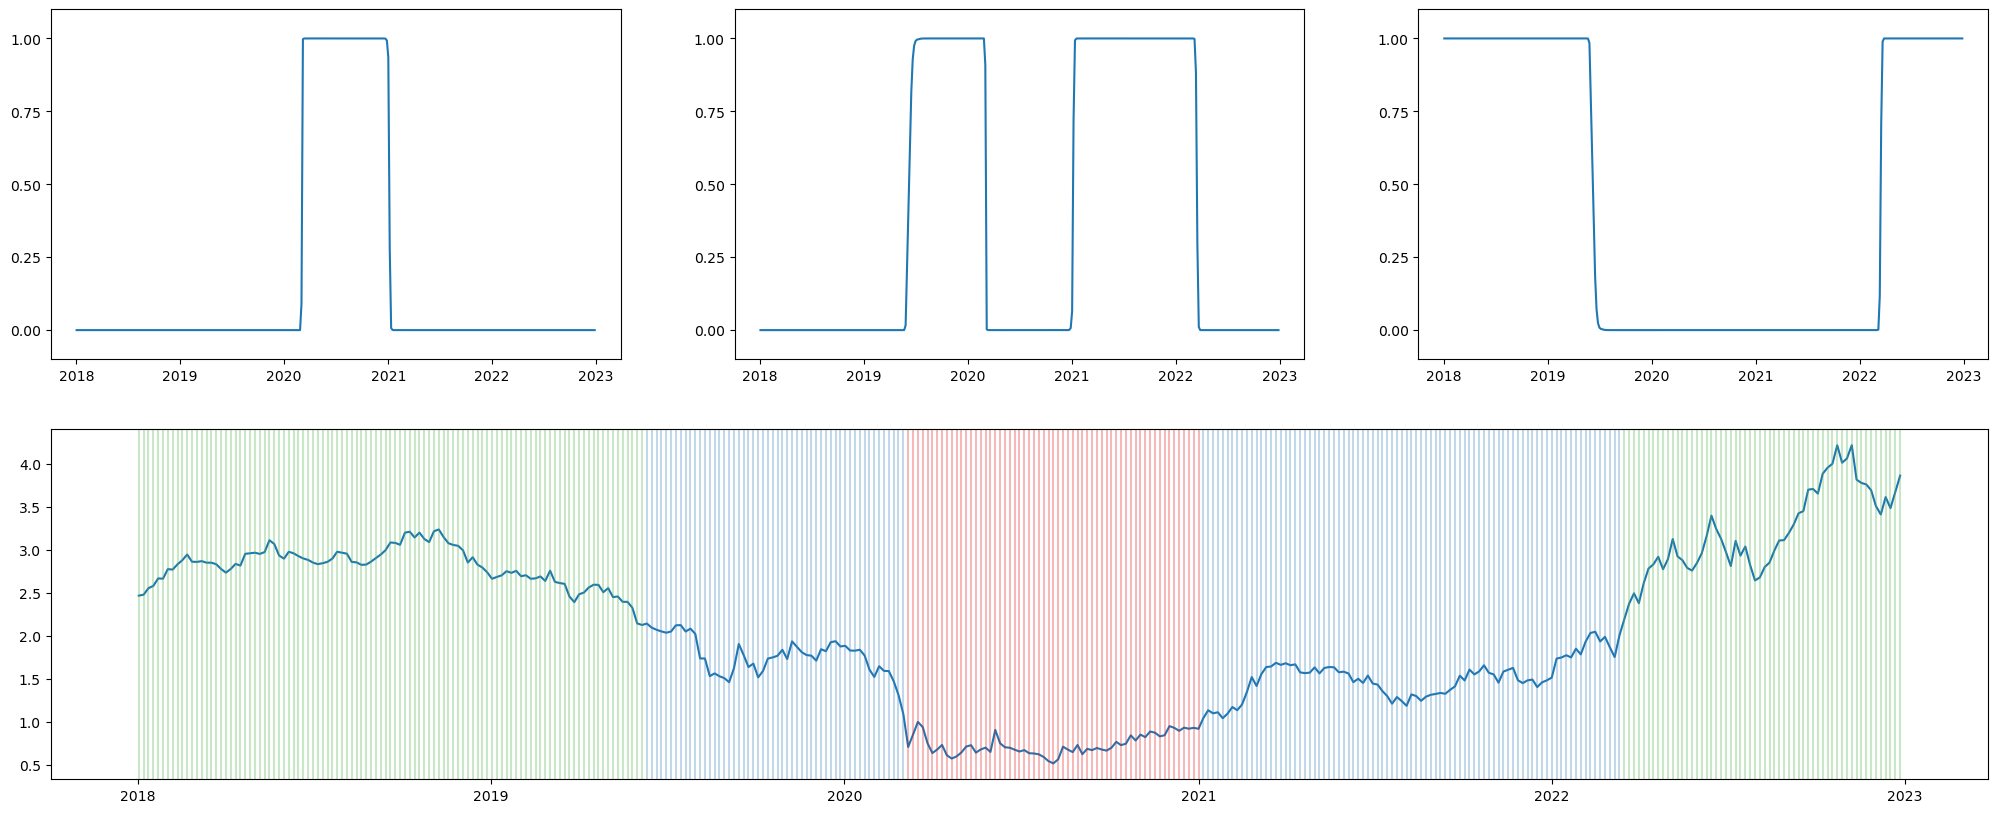

Mean of the states: 
[0.7364 1.6114 2.9497] 

Standard deviation of the states: 
[0.1194 0.2596 0.4009] 

Transition Probability Matrix: 
[[0.9837 0.0163 0.    ]
 [0.0071 0.9858 0.0071]
 [0.     0.0062 0.9938]] 

Intial Probability: 
[0. 0. 1.] 

Estimating with 4 states
Iterations: 30, diff: 0.0077


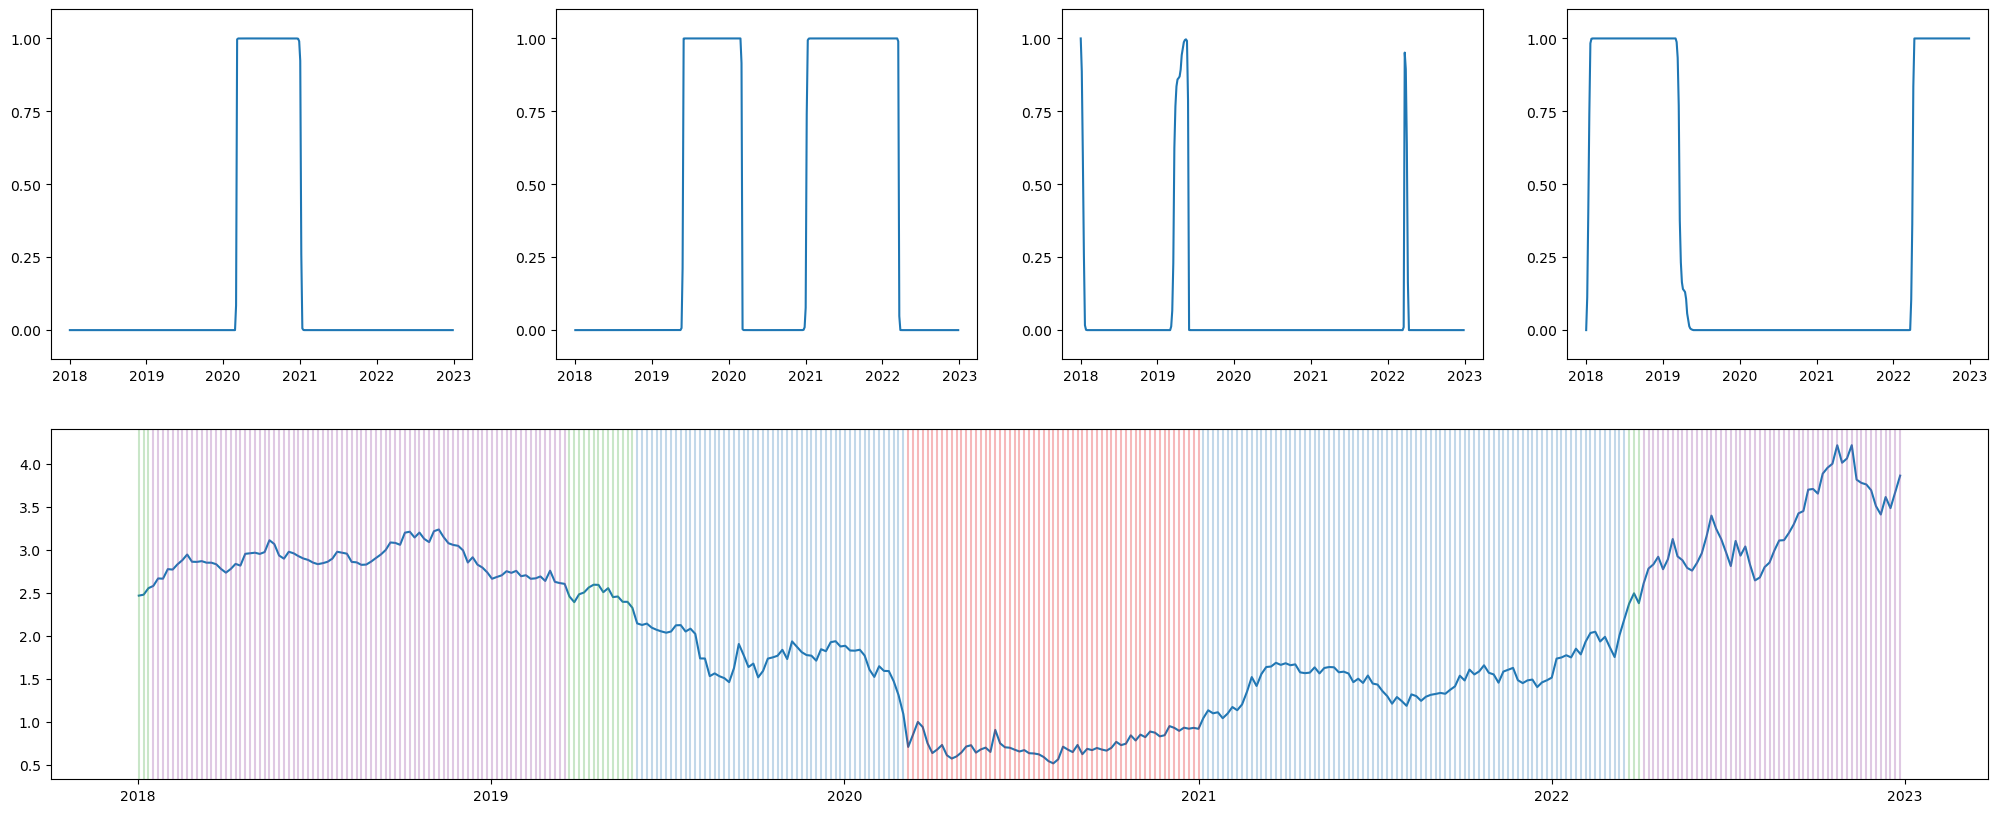

Mean of the states: 
[0.7362 1.6228 2.4741 3.0277] 

Standard deviation of the states: 
[0.1192 0.2688 0.0772 0.3677] 

Transition Probability Matrix: 
[[0.9837 0.0163 0.     0.    ]
 [0.0069 0.9861 0.0069 0.    ]
 [0.     0.0552 0.8325 0.1123]
 [0.     0.     0.0073 0.9927]] 

Intial Probability: 
[0. 0. 1. 0.] 



In [7]:
results = {f"{key}":{} for key in ["i", "ii", "iii", "iv"]}


for n in range(2,5):
    print(f"Estimating with {n} states")
    mu_hat, sigma_hat, P_hat, pi_hat, sum_log_like = markov_regimes(series, N=n)
    print(f"Mean of the states: \n{mu_hat} \n")
    print(f"Standard deviation of the states: \n{sigma_hat} \n")
    print(f"Transition Probability Matrix: \n{P_hat} \n")
    print(f"Intial Probability: \n{pi_hat} \n")
    
    results["i"][n] = (mu_hat, sigma_hat, P_hat, pi_hat, sum_log_like)

### ii. Different means, constant variance

Estimating 2 states with constant variance and different mean
Iterations: 5, diff: 0.0027


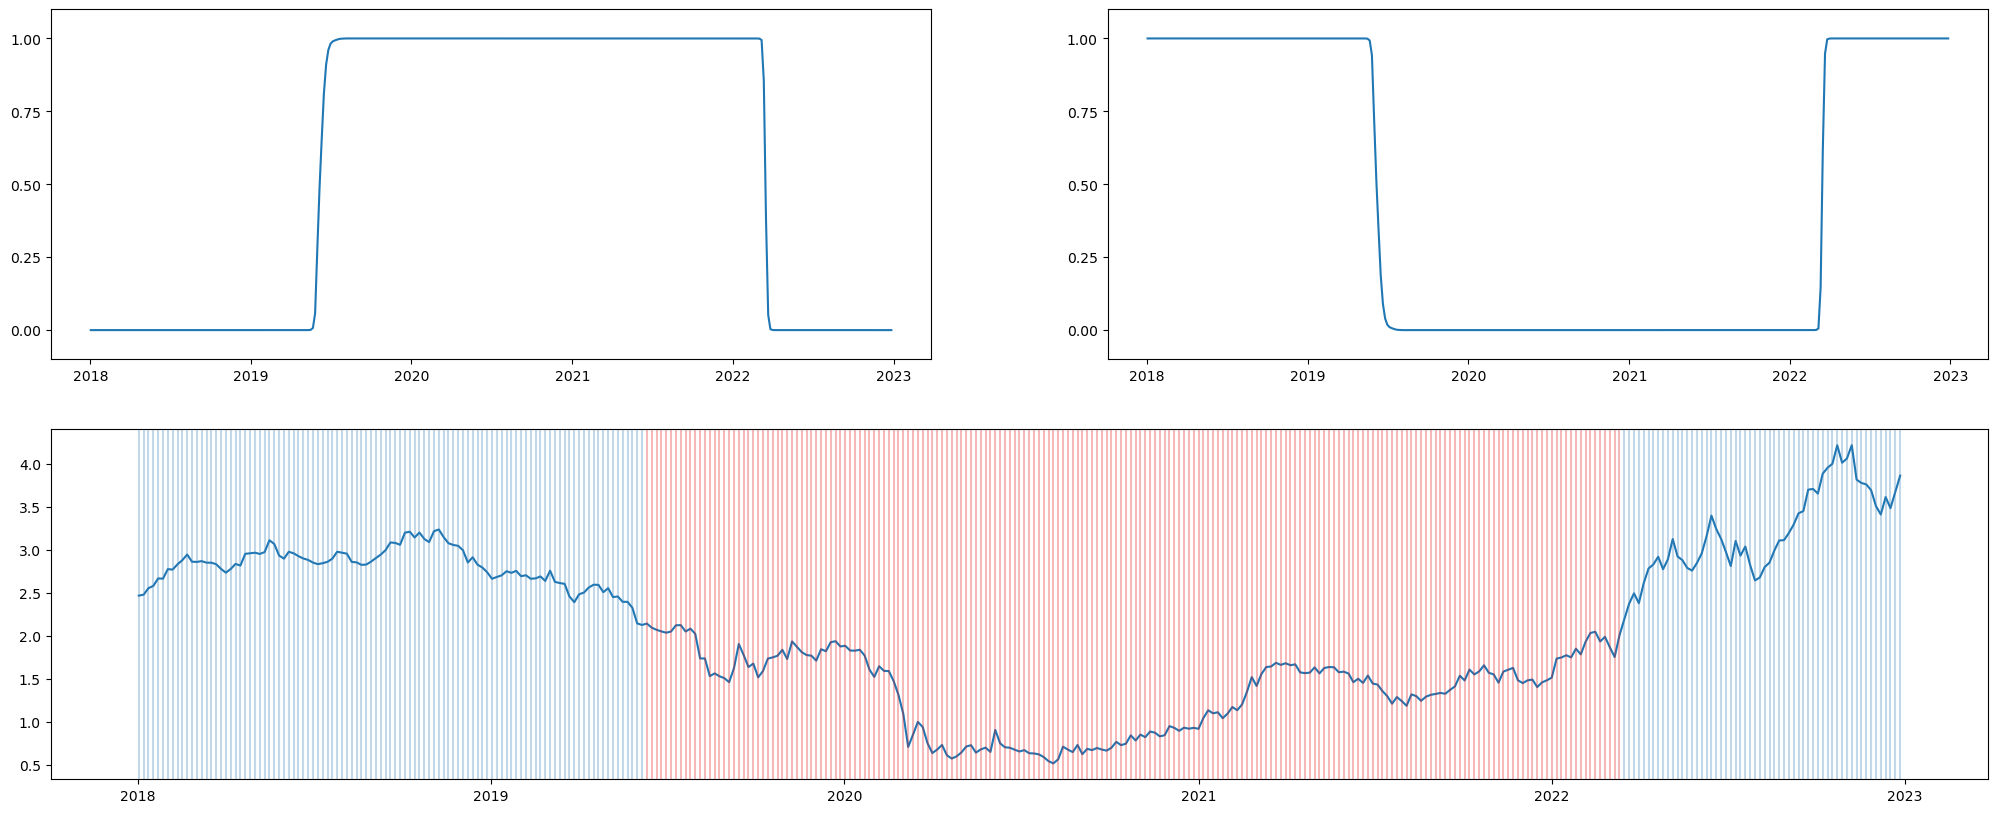

Mean of the states: 
[1.3471 2.9505] 

Transition Probability Matrix: 
[[0.9951 0.0049]
 [0.0062 0.9938]] 

Intial Probability: 
[0. 1.] 

Estimating 3 states with constant variance and different mean
Iterations: 11, diff: 0.0029


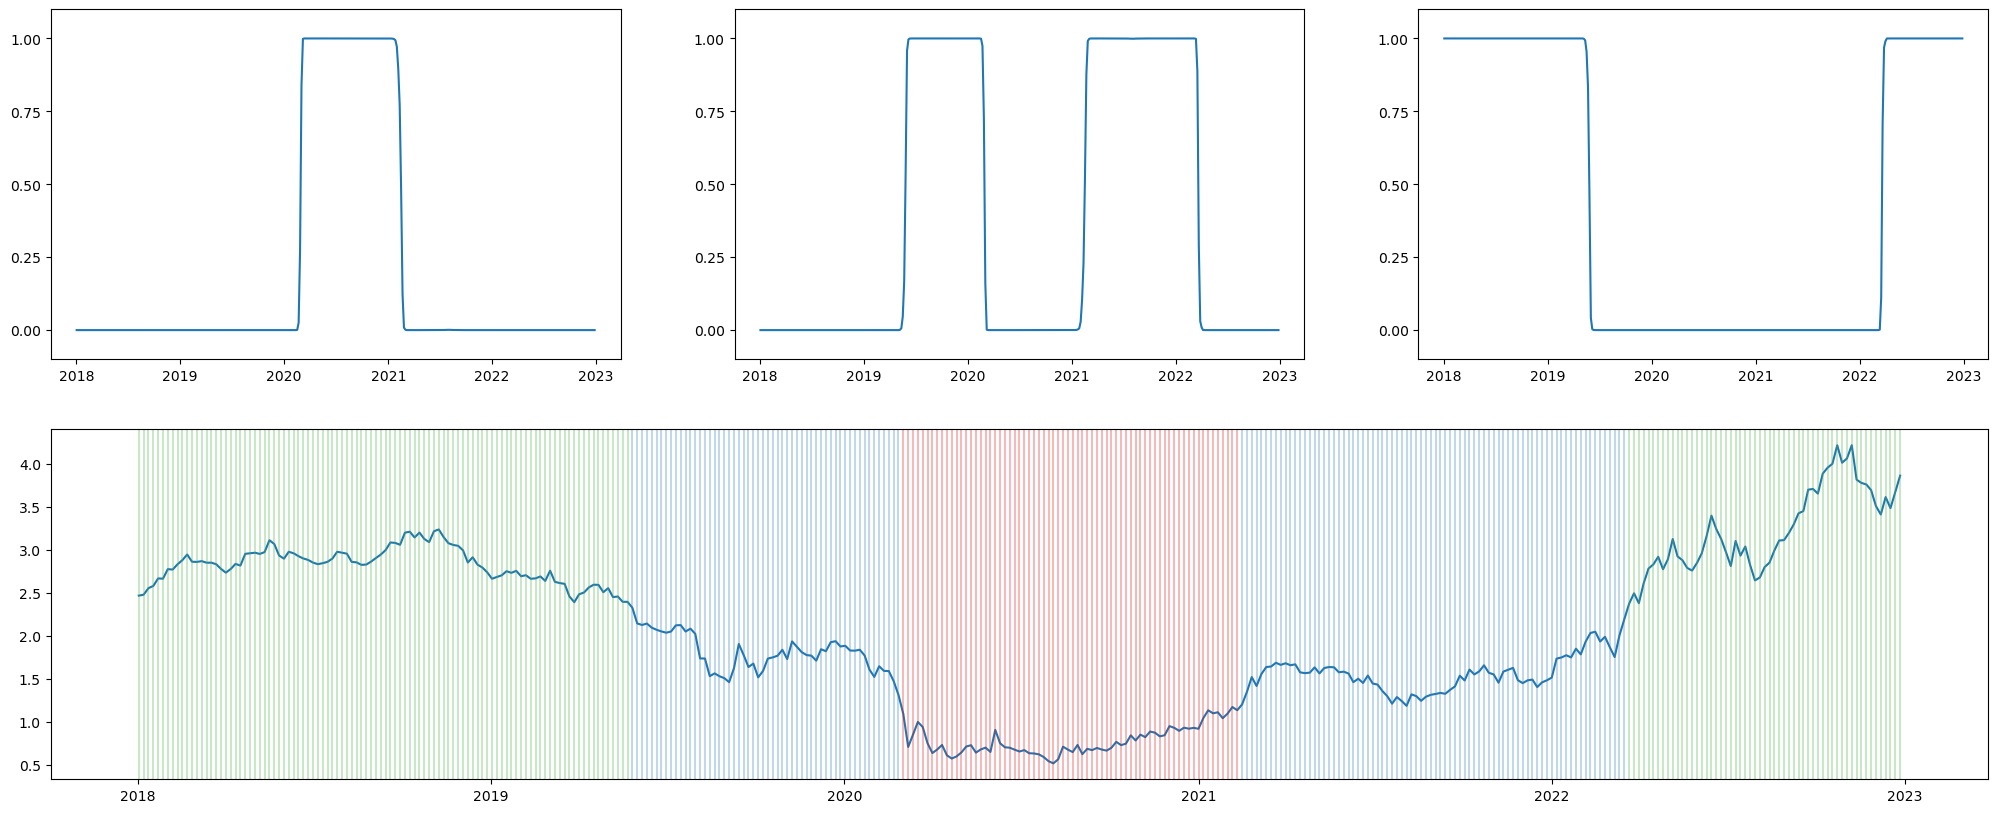

Mean of the states: 
[0.7854 1.6608 2.9673] 

Transition Probability Matrix: 
[[0.9857 0.0143 0.    ]
 [0.0074 0.9852 0.0074]
 [0.     0.0063 0.9937]] 

Intial Probability: 
[0. 0. 1.] 

Estimating 4 states with constant variance and different mean
Iterations: 13, diff: 0.0033


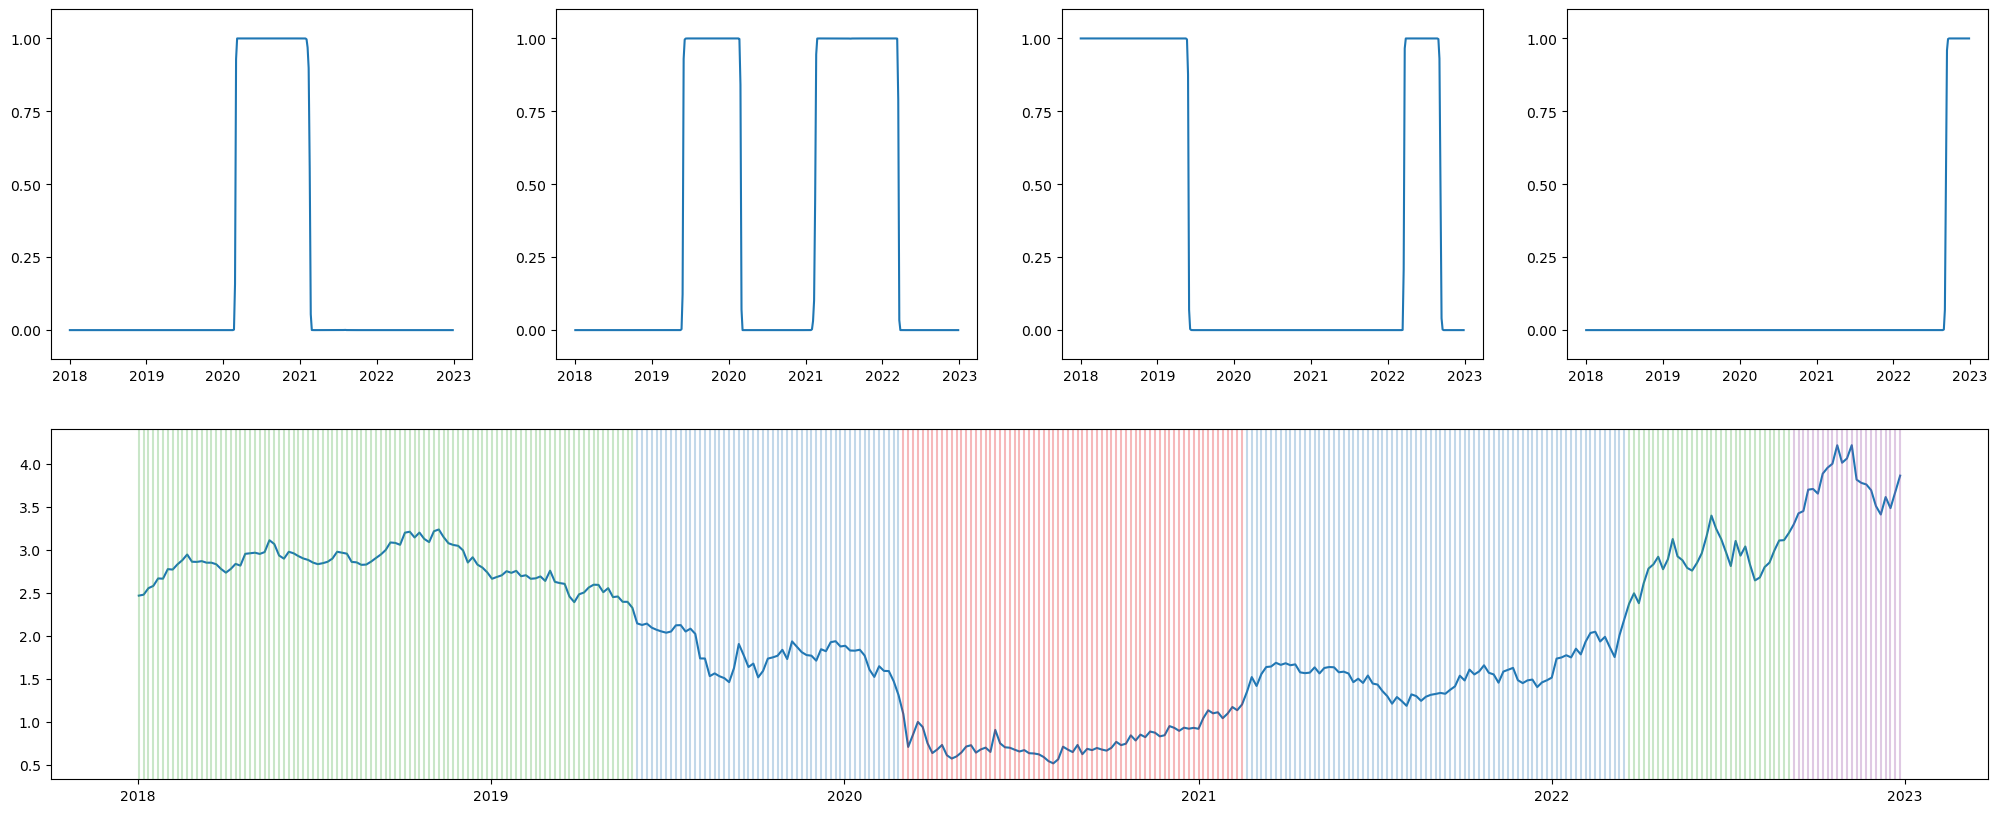

Mean of the states: 
[0.7856 1.6565 2.8338 3.7529] 

Transition Probability Matrix: 
[[0.9858 0.0142 0.     0.    ]
 [0.0075 0.9851 0.0074 0.    ]
 [0.     0.0073 0.9855 0.0073]
 [0.     0.     0.     1.    ]] 

Intial Probability: 
[0. 0. 1. 0.] 



In [8]:
for n in range(2,5):
    print(f"Estimating {n} states with constant variance and different mean")
    mu_hat, sigma_hat, P_hat, pi_hat,sum_log_like = markov_regimes(series, n, False, True)
    print(f"Mean of the states: \n{mu_hat} \n")
    print(f"Transition Probability Matrix: \n{P_hat} \n")
    print(f"Intial Probability: \n{pi_hat} \n")
    
    results["ii"][n] = mu_hat, sigma_hat, P_hat, pi_hat, sum_log_like

### iii. Constant mean, different variance

Estimating 2 states with constant mean and different variance
Iterations: 119, diff: 0.0076


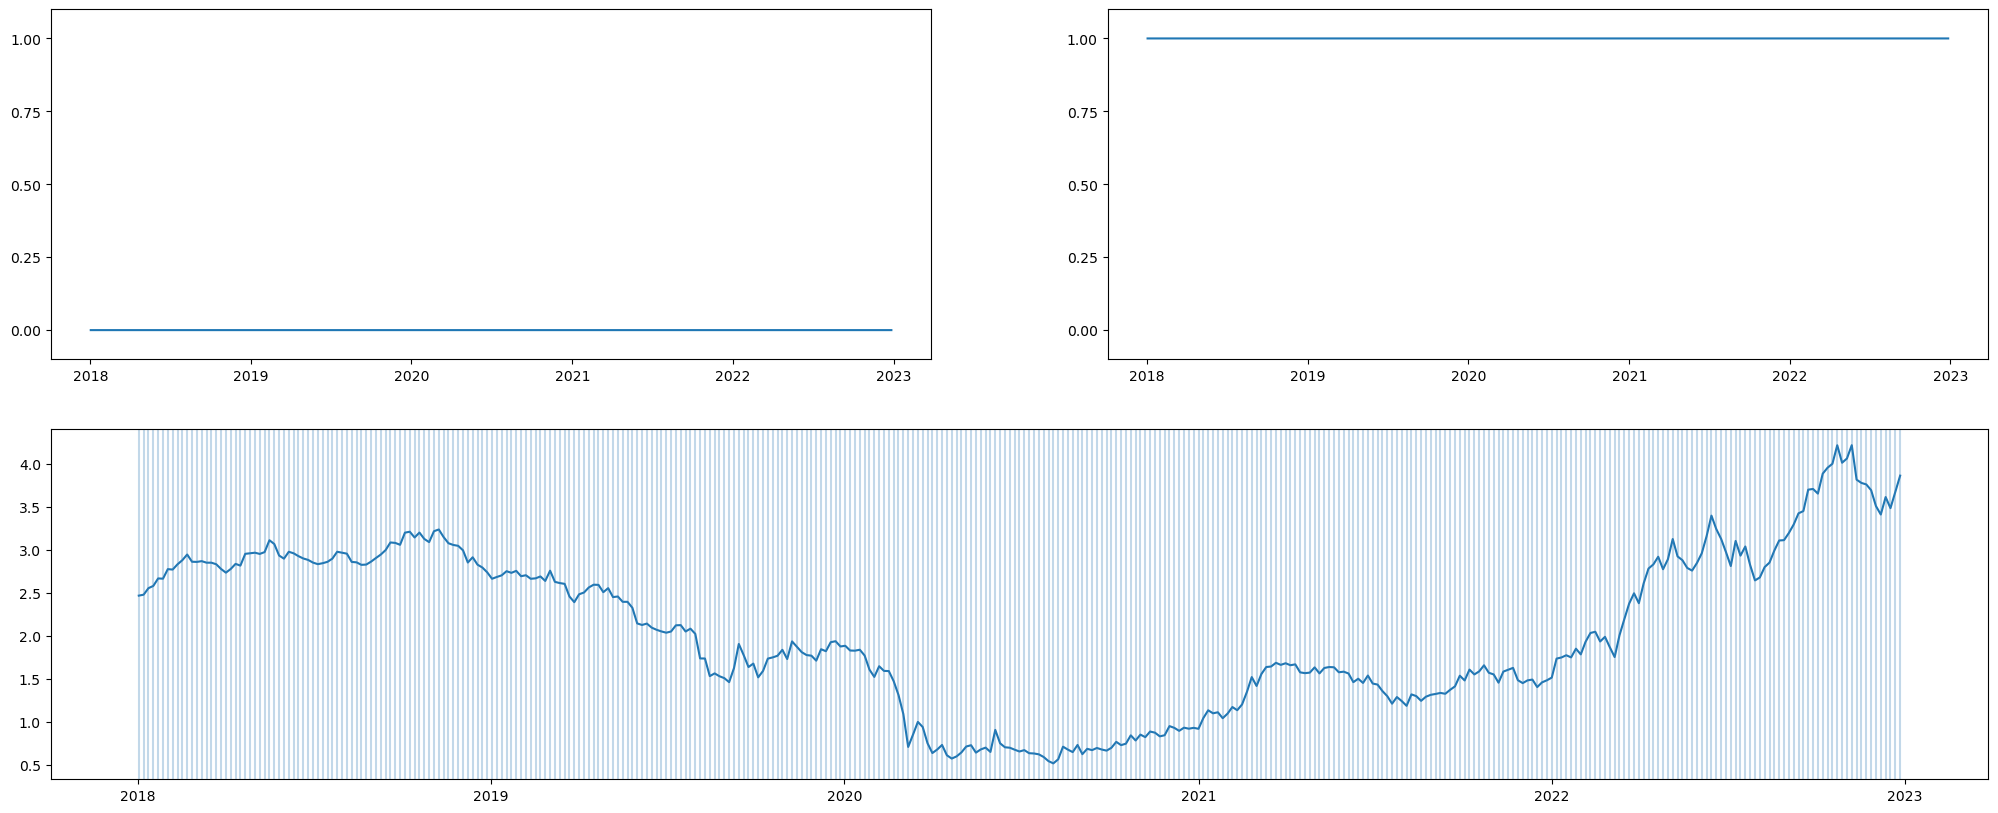

Standard deviation of the states: 
[0.4036 0.9083] 

Transition Probability Matrix: 
[[0. 1.]
 [0. 1.]] 

Intial Probability: 
[0. 1.] 

Estimating 3 states with constant mean and different variance
Iterations: 96, diff: 0.0068


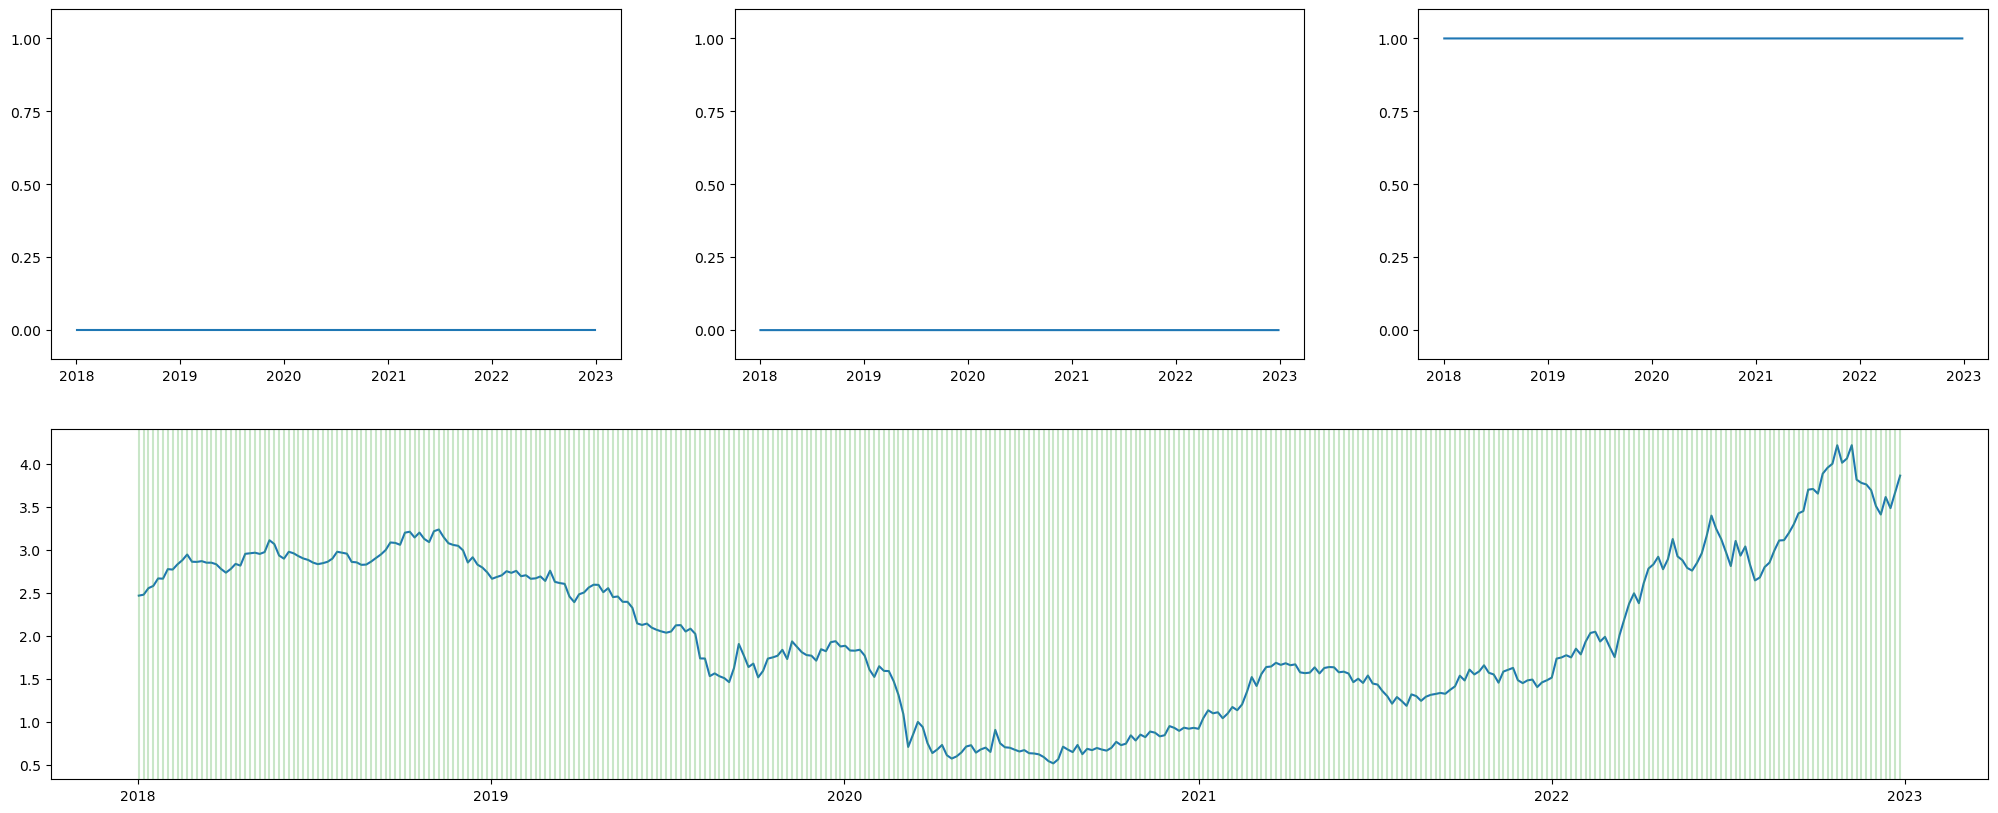

Standard deviation of the states: 
[0.4036 0.4036 0.9083] 

Transition Probability Matrix: 
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]] 

Intial Probability: 
[0. 0. 1.] 

Estimating 4 states with constant mean and different variance
Iterations: 118, diff: 0.0095


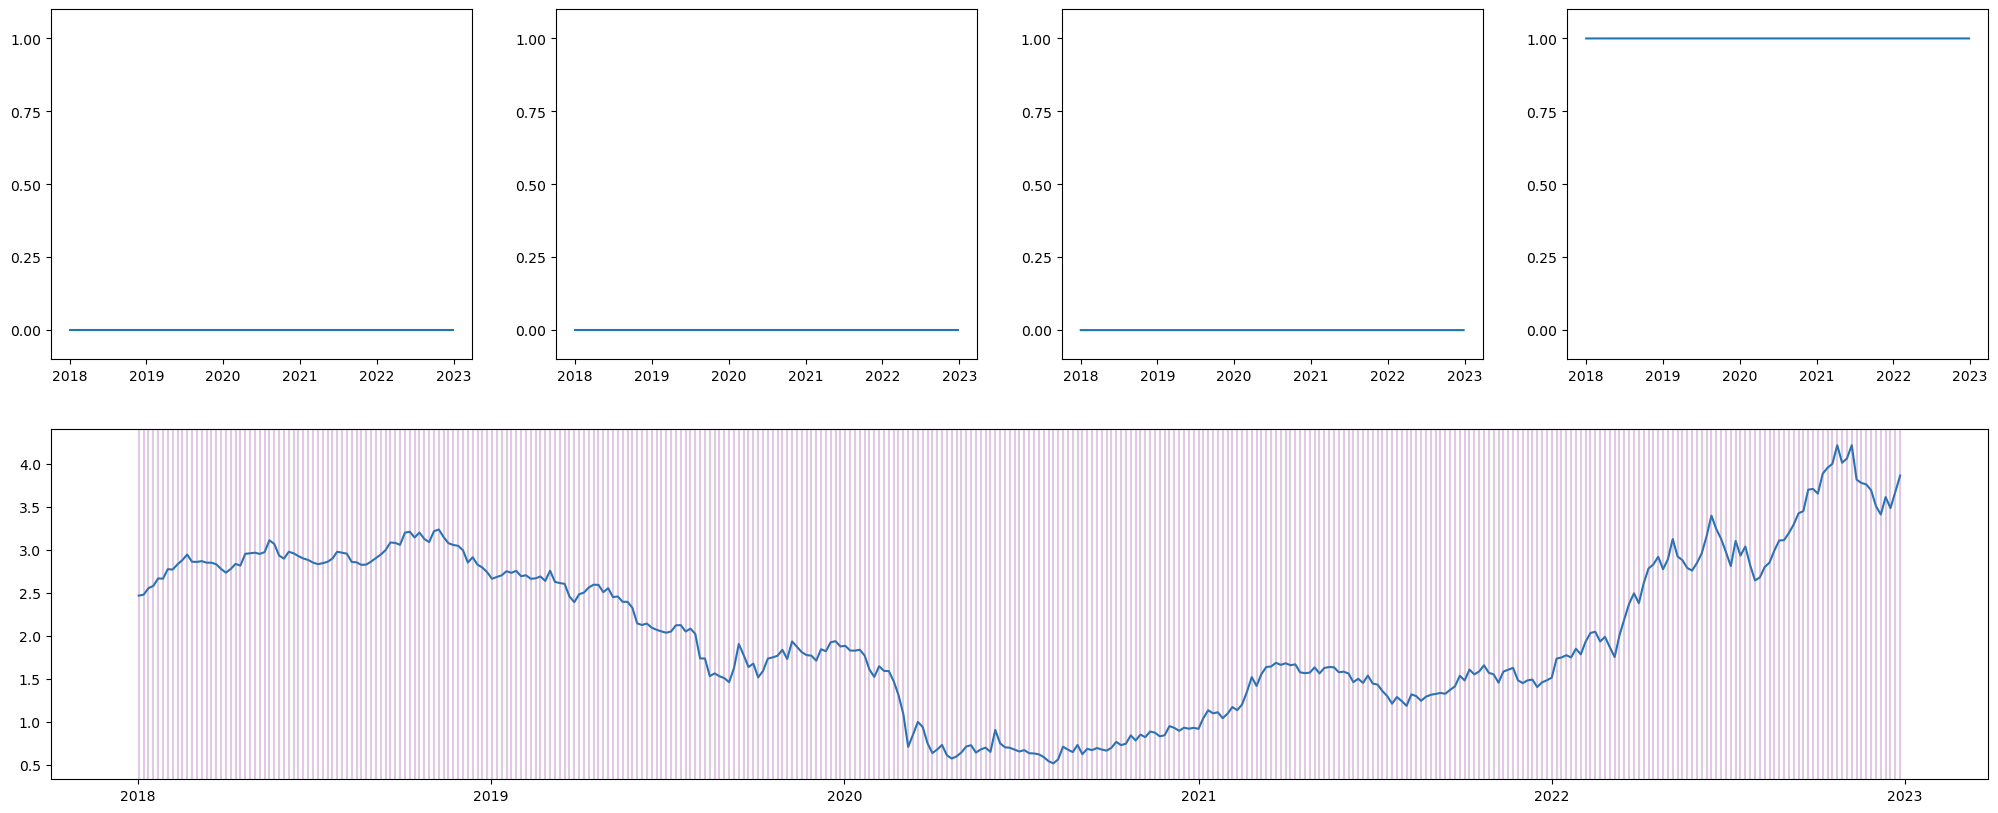

Standard deviation of the states: 
[0.4036 0.4036 0.4036 0.9083] 

Transition Probability Matrix: 
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]] 

Intial Probability: 
[0. 0. 0. 1.] 



In [9]:
for n in range(2,5):
    print(f"Estimating {n} states with constant mean and different variance")
    mu_hat, sigma_hat, P_hat, pi_hat,sum_log_like = markov_regimes(series, n, True, False)
    print(f"Standard deviation of the states: \n{sigma_hat} \n")
    print(f"Transition Probability Matrix: \n{P_hat} \n")
    print(f"Intial Probability: \n{pi_hat} \n")
    
    results["iii"][n] = mu_hat, sigma_hat, P_hat, pi_hat, sum_log_like

### iv. Different mean, different variance

Estimating with 2 states with varying means and variance
Iterations: 6, diff: 0.0024


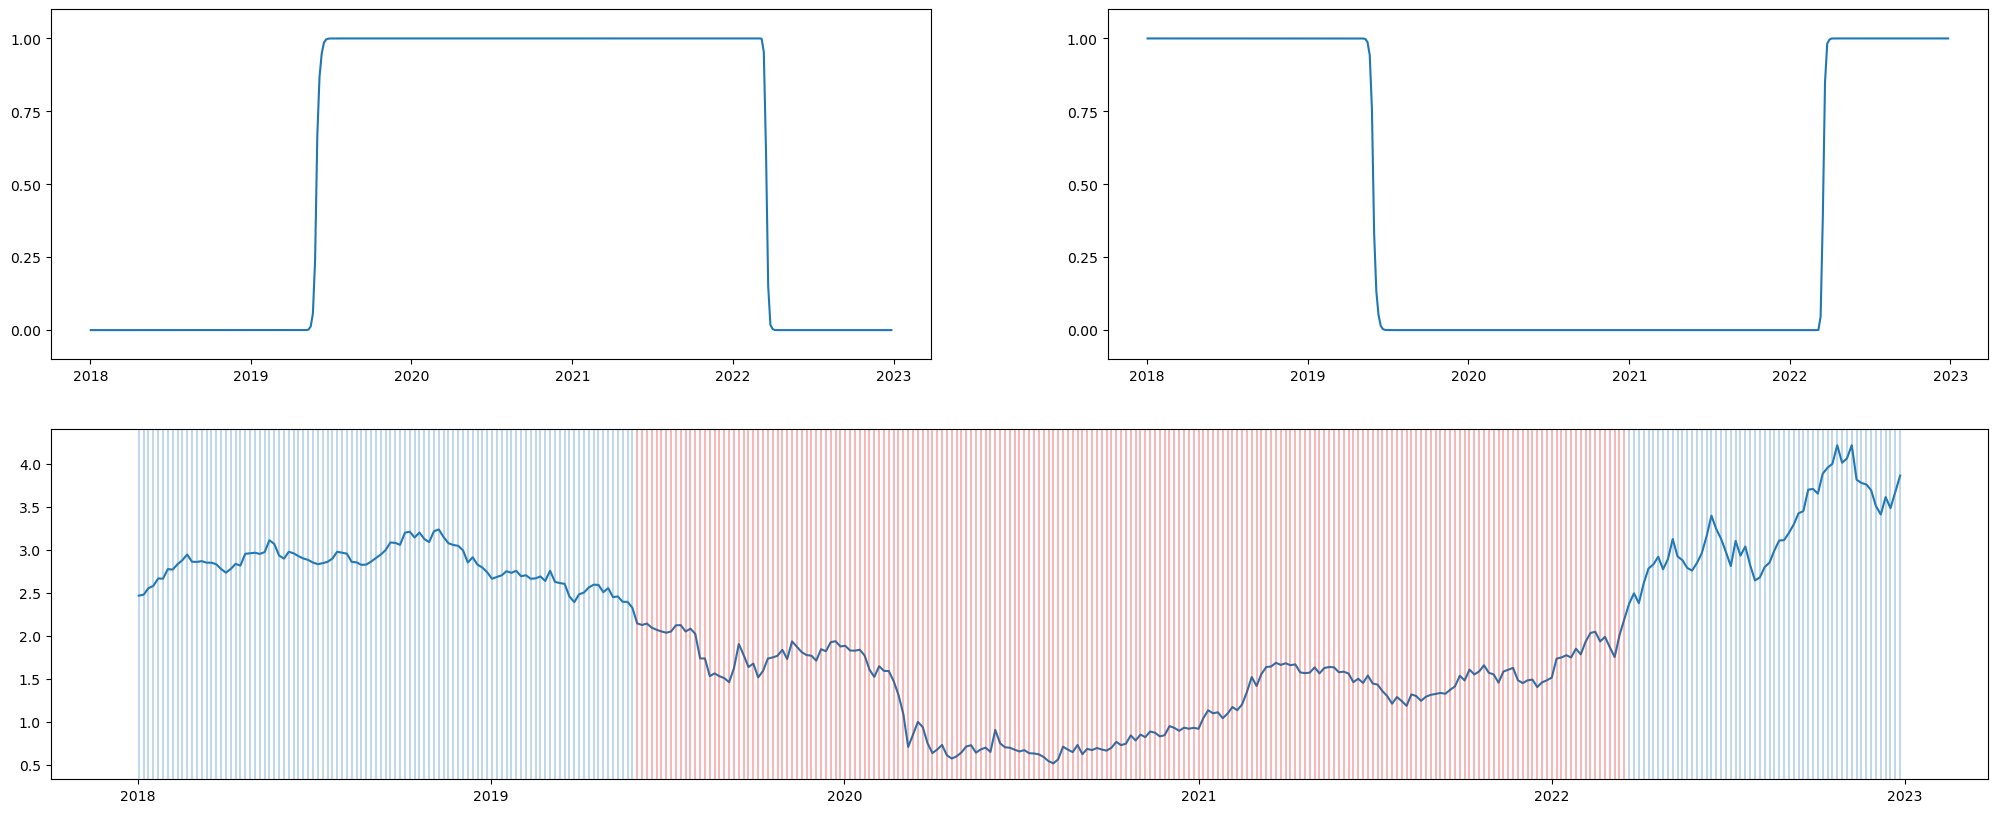

Mean of the states: 
[1.3555 2.9609] 

Standard deviation of the states: 
[0.4674 0.3926] 

Transition Probability Matrix: 
[[0.9951 0.0049]
 [0.0063 0.9937]] 

Intial Probability: 
[0. 1.] 

Estimating with 3 states with varying means and variance
Iterations: 24, diff: 0.0094


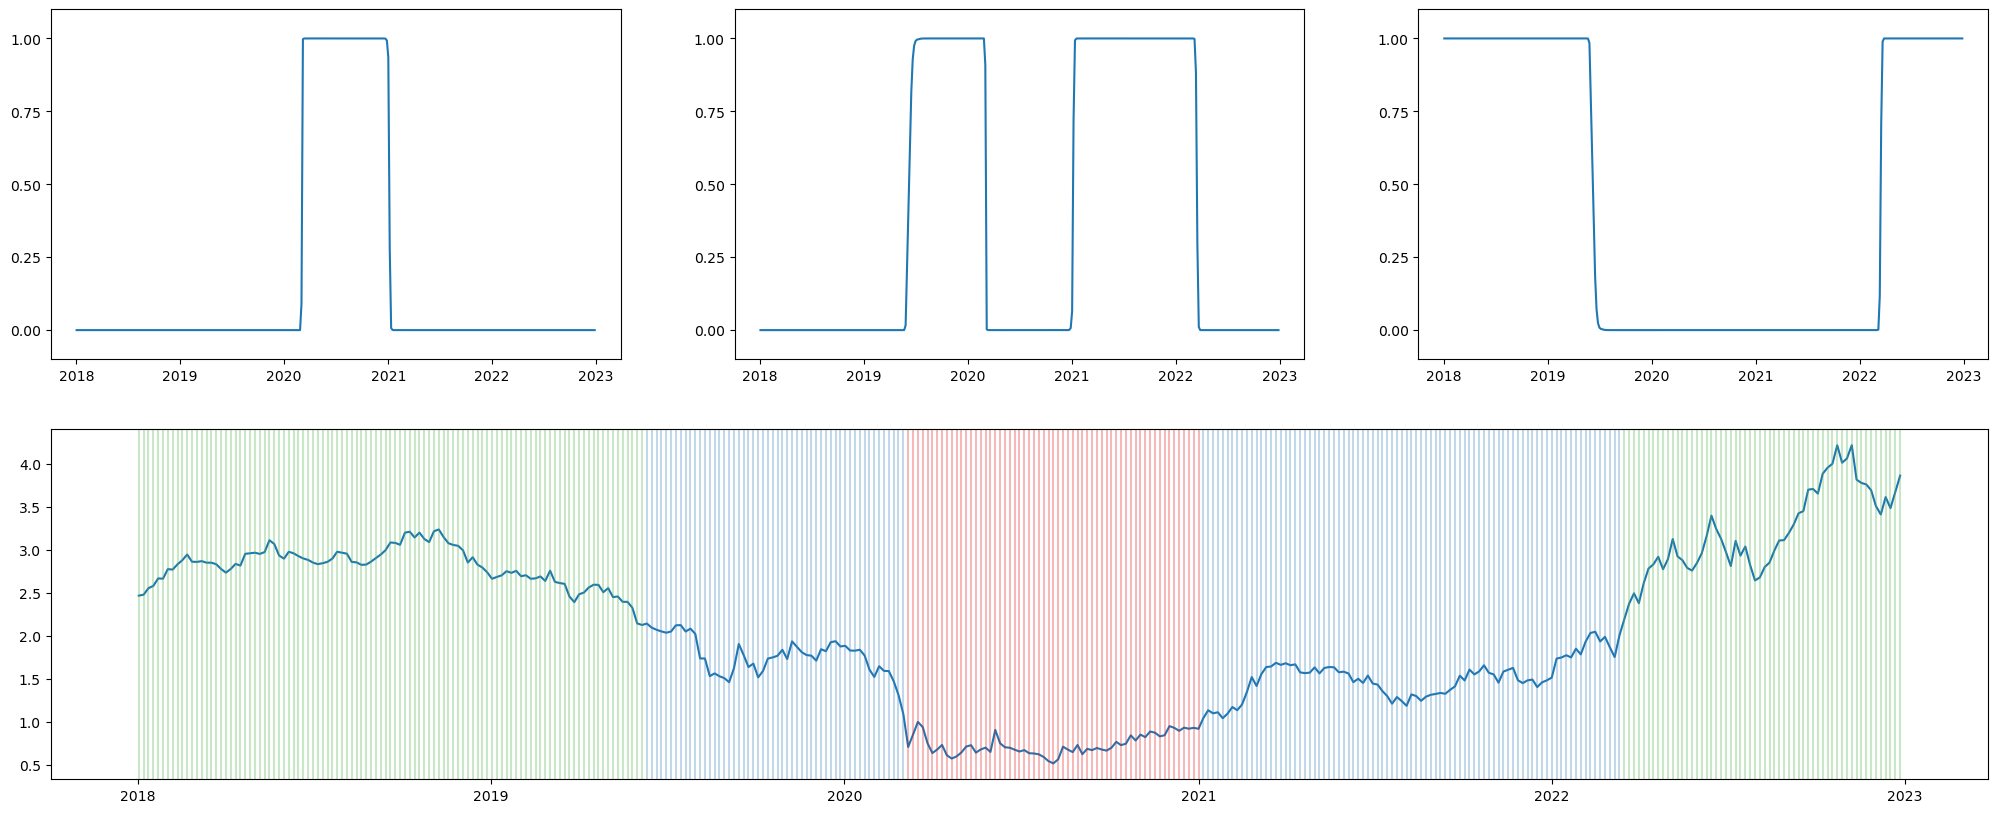

Mean of the states: 
[0.7364 1.6114 2.9497] 

Standard deviation of the states: 
[0.1194 0.2596 0.4009] 

Transition Probability Matrix: 
[[0.9837 0.0163 0.    ]
 [0.0071 0.9858 0.0071]
 [0.     0.0062 0.9938]] 

Intial Probability: 
[0. 0. 1.] 

Estimating with 4 states with varying means and variance
Iterations: 30, diff: 0.0077


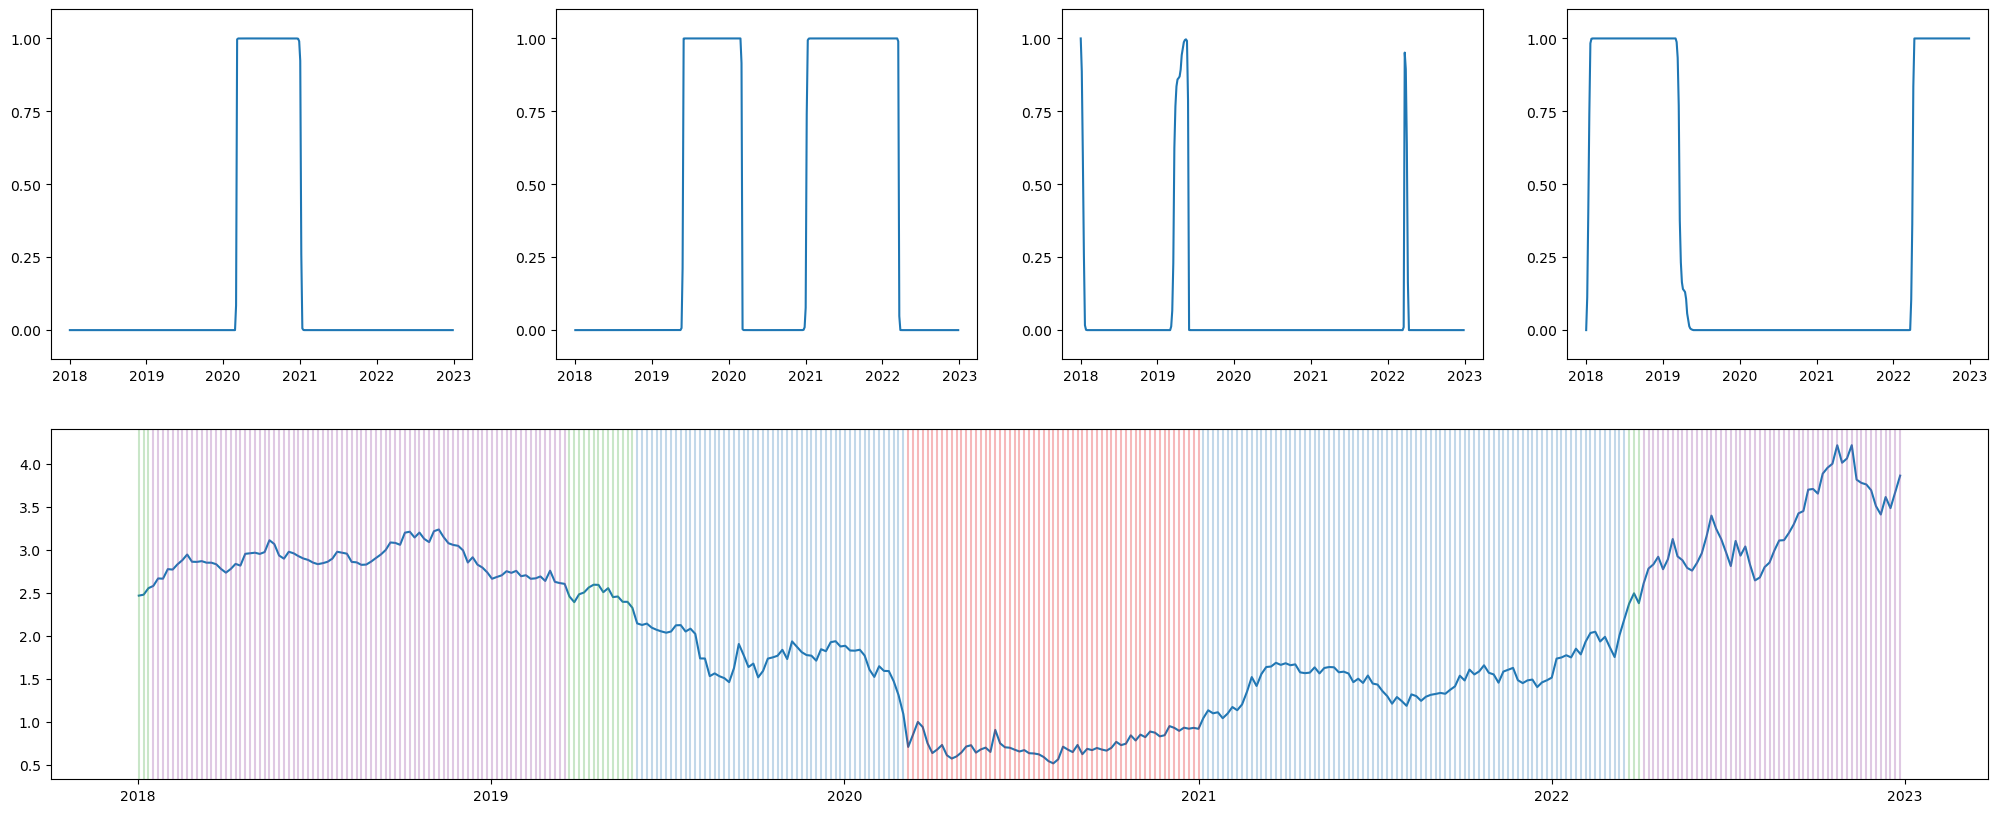

Mean of the states: 
[0.7362 1.6228 2.4741 3.0277] 

Standard deviation of the states: 
[0.1192 0.2688 0.0772 0.3677] 

Transition Probability Matrix: 
[[0.9837 0.0163 0.     0.    ]
 [0.0069 0.9861 0.0069 0.    ]
 [0.     0.0552 0.8325 0.1123]
 [0.     0.     0.0073 0.9927]] 

Intial Probability: 
[0. 0. 1. 0.] 



In [10]:
for n in range(2,5):
    print(f"Estimating with {n} states with varying means and variance")
    mu_hat, sigma_hat, P_hat, pi_hat, sum_log_like = markov_regimes(series, N=n)
    print(f"Mean of the states: \n{mu_hat} \n")
    print(f"Standard deviation of the states: \n{sigma_hat} \n")
    print(f"Transition Probability Matrix: \n{P_hat} \n")
    print(f"Intial Probability: \n{pi_hat} \n")
    
    results["iv"][n] = (mu_hat, sigma_hat, P_hat, pi_hat, sum_log_like)


From the above results and plots, it is evident that hidden states exists for the following cases:

* Different means and constant variance
* Different means and different variance

However, there is no significant HMM exists in case of Constant mean and Different variance, which is evident from the Transition Probability Matrix as the process jumps into the final state with probability of 1, regardless of the current state.

<br></br>

# Step 3

Akaike Information Criteria and Schwarz Information Criteria are used to compare the models estimated in Step 2 and to rank the models based on their performance. Lower the Information Criteria, the model performs better.

### a) Comparing models that had different mu values

In [11]:
def information_criterion(log_likelihood, n_regimes, n):
    k = n_regimes * 3 + n_regimes**2
    akaike = 2 * k - 2 * log_likelihood
    schwarz = k * np.log(n) - 2 * log_likelihood
    
    return akaike, schwarz

In [12]:
choices = ["different mu", "different sigma", "different mu and different sigma"]
performance = {i: {} for i in choices}

for k, v in results["ii"].items():
    akaike, schwarz = information_criterion(v[4], k, len(series))
    
    performance[choices[0]][k] = akaike, schwarz
    
    print(f"Information criterion of model with {k} regimes: \n AIC: {akaike:.4f} \t SIC: {schwarz:.4f}\n")

Information criterion of model with 2 regimes: 
 AIC: 1074.2417 	 SIC: 1113.2406

Information criterion of model with 3 regimes: 
 AIC: 1108.0261 	 SIC: 1178.2243

Information criterion of model with 4 regimes: 
 AIC: 1141.1004 	 SIC: 1250.2975



### b) Comparing models that had different sigma values

In [13]:
for k, v in results["iii"].items():
    akaike, schwarz = information_criterion(v[4], k, len(series))
    
    performance[choices[1]][k] = akaike, schwarz
    
    print(f"Information criterion of model with {k} regimes: \n AIC: {akaike:.4f} \t SIC: {schwarz:.4f}\n")

Information criterion of model with 2 regimes: 
 AIC: 1055.8251 	 SIC: 1094.8241

Information criterion of model with 3 regimes: 
 AIC: 1071.8251 	 SIC: 1142.0233

Information criterion of model with 4 regimes: 
 AIC: 1091.8251 	 SIC: 1201.0223



### c) Comparing models that had different mu values and different sigma values

In [14]:
for k, v in results["iv"].items():
    akaike, schwarz = information_criterion(v[4], k, len(series))
    
    performance[choices[2]][k] = akaike, schwarz
    
    print(f"Information criterion of model with {k} regimes: \n AIC: {akaike:.4f} \t SIC: {schwarz:.4f}\n")

Information criterion of model with 2 regimes: 
 AIC: 1074.9954 	 SIC: 1113.9944

Information criterion of model with 3 regimes: 
 AIC: 1109.9084 	 SIC: 1180.1065

Information criterion of model with 4 regimes: 
 AIC: 1144.6222 	 SIC: 1253.8193



### d) Comparing and ranking the models

In [15]:
df_list = []

for condition, state_dict in performance.items():
    for state, (aic, sic) in state_dict.items():
        df_list.append(pd.DataFrame({'Condition': condition,
                                      'State': state,
                                      'AIC': aic,
                                      'SIC': sic}, index=[0]))

df = pd.concat(df_list)

df_ranked = df.sort_values(by='AIC')
df_ranked.index = range(1, len(df)+1)

df_ranked

,Condition,State,AIC,SIC
1,different sigma,2,1055.825129,1094.824103
2,different sigma,3,1071.825129,1142.023282
3,different mu,2,1074.241661,1113.240635
4,different mu and different sigma,2,1074.995381,1113.994355
5,different sigma,4,1091.825129,1201.022255
6,different mu,3,1108.026138,1178.224291
7,different mu and different sigma,3,1109.908391,1180.106543
8,different mu,4,1141.100389,1250.297515
9,different mu and different sigma,4,1144.622218,1253.819343


Note that, in the above table, ranks 1, 2 and 5 are the conditions with different sigma and constant mu, which only had one significant hidden state. Below table omits different sigma and ranks the models based just on other conditions.

In [16]:
df_new = df[df["Condition"] != "different sigma"]
df_new_ranked = df_new.sort_values(by="AIC")

df_new_ranked.index = range(1, len(df_new)+1)
df_new_ranked

,Condition,State,AIC,SIC
1,different mu,2,1074.241661,1113.240635
2,different mu and different sigma,2,1074.995381,1113.994355
3,different mu,3,1108.026138,1178.224291
4,different mu and different sigma,3,1109.908391,1180.106543
5,different mu,4,1141.100389,1250.297515
6,different mu and different sigma,4,1144.622218,1253.819343


Since sigma does not have significance with the number of states, performance of models with different mu and the models with different mu and sigma are close to each other, given the number of hidden states. The models with 2 hidden states has better performance over other models.

# Step 4: HMM with an AR(1) process

AR(1) process is given by $y_t = \rho_i y_{t-1} + \epsilon_t$, 

where $\rho_i$ is the coefficient of the hidden state $i$. 
$\epsilon_t$ follows a normal distribution with mean $\mu_i$ and variance $\sigma_i^2$. However, based on the ranking in the previous step, we will keep $\sigma$ constant. i.e, $\sigma_i = \sigma$ for all $i$.

In [17]:
def likelihood_AR1(xi_prob, mu, sigma, rho, y, y_1):
    phi = norm.pdf((y - mu - rho*y_1) / sigma)
    y_like = np.dot(xi_prob, phi)

    return y_like


def forward_alg_AR1(pi_hat0, N, T, P, mu, sigma, rho, Y):

    xi_prob_t = np.zeros((T-1, N))
    xi_prob_t1 = np.zeros((T-1, N))

    # Case t=1
    y_like = likelihood_AR1(pi_hat0, mu, sigma, rho, Y[1], Y[0])
    for ss in range(0, N):
        phi = np.zeros((N))
        for ss2 in range(0, N):
            phi[ss2] = norm.pdf((Y[0] - mu[ss2]) / sigma[ss2])
    xi_prob_t[0, :] = np.multiply(pi_hat0, phi) / y_like
    for ss in range(0, N):
        xi_prob_t1[0, ss] = np.dot(P[:, ss], xi_prob_t[0, :])

    for tt in range(1, T-1):
        y_like = likelihood_AR1(xi_prob_t1[tt - 1, :], mu, sigma, rho, Y[tt+1], Y[tt])
        for ss in range(0, N):
            phi = np.zeros((N))
            for ss2 in range(0, N):
                phi[ss2] = norm.pdf((Y[tt+1] - mu[ss2] -rho[ss2]*Y[tt]) / sigma[ss2])

        xi_prob_t[tt, :] = np.multiply(xi_prob_t1[tt - 1, :], phi) / y_like
        for ss in range(0, N):
            xi_prob_t1[tt, ss] = np.dot(P[:, ss], xi_prob_t[tt, :])

    return xi_prob_t, xi_prob_t1


def M_step_func_AR1(xi_prob, P, N, T, Y):

    mu_hat = np.zeros((N))
    rho_hat = np.zeros((N))
    sigma_hat = 0
    P_hat = np.zeros((N, N))
    pi_hat = np.zeros((N))

    for ss in range(0, N):
        xi_y = np.sqrt(xi_prob[:, ss]) * Y[1:]
        z = np.stack((np.ones(T-1), Y[0:-1]), axis=1)
        xi_z = np.zeros((T-1, N))
        xi_z[:, 0]  = np.sqrt(xi_prob[:, ss]) * z[:,0]
        xi_z[:, 1]  = np.sqrt(xi_prob[:, ss]) * z[:,1]
        z_xi_z_inv = np.linalg.inv(np.dot(xi_z.T, xi_z))
        beta_hat = np.dot(z_xi_z_inv, np.dot(xi_z.T, xi_y))
        
        mu_hat[ss] = beta_hat[0]
        rho_hat[ss] = beta_hat[1]

        residuals = Y[1:] - np.dot(z, beta_hat)
        xi_y_mu2 = np.dot(xi_prob[:, ss], residuals ** 2)
        sigma_hat += xi_y_mu2

        for ss2 in range(0, N):
            P_hat[ss, ss2] = np.sum(P[ss, ss2, 1:]) / np.sum(
                P[ss, :, 1:]
            )

        pi_hat[ss] = xi_prob[0, ss]
        
    sigma_hat = np.sqrt(sigma_hat / T)
    sigma_hat = sigma_hat * np.ones((N))

    return mu_hat, rho_hat, sigma_hat, P_hat, pi_hat


def log_likelihood_AR1(xi_prob, T, pi_hat0, P, mu, sigma, rho, Y):

    y_like = np.zeros(T-1)
    for tt in range(0, T-1):
        y_like[tt] = likelihood_AR1(xi_prob[tt,:], mu, sigma, rho, Y[tt+1], Y[tt])

    sum_log_like = np.sum(np.log(y_like))
    k = (np.prod(mu.shape) + np.prod(sigma.shape) + np.prod(rho.shape))
    k += (np.prod(pi_hat0.shape) + np.prod(P.shape))
    n = len(Y) - 1
    akaike = 2*k - 2*sum_log_like
    schwarz = k*np.log(n) - 2*sum_log_like

    return sum_log_like, akaike, schwarz


Iterations: 158, diff: 0.0099


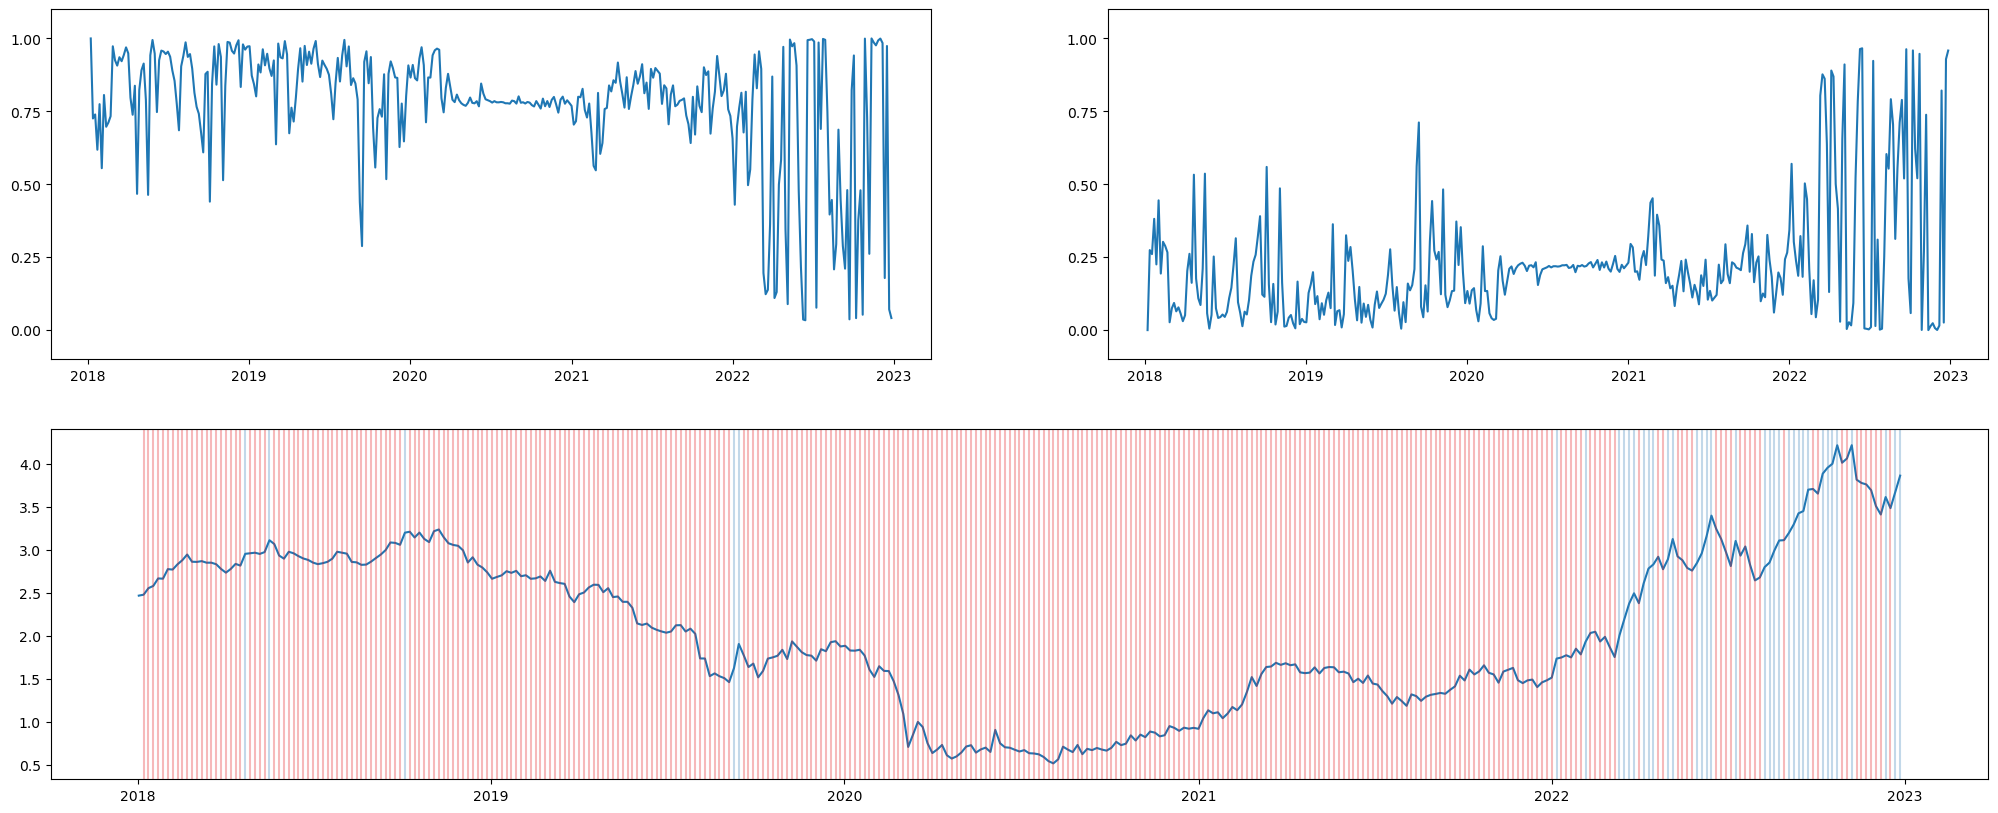

Co-efficients of the states: 
 [0.983 1.042] 

Mean of the states: 
[ 0.018  -0.0142] 

Transition Probability Matrix: 
[[0.8411 0.1589]
 [0.5487 0.4513]] 

Intial Probability: 
[1. 0.] 



In [18]:
T = len(series)
mean = series.mean()
std = series.std()
N = 2

# initial guesses
mu_hat0 = np.linspace(mean - std * N / 2, mean + std * N / 2, num=N)
rho_hat0 = np.ones((N)) * std
sigma_hat0 = np.ones(N) * std
P_hat0 = np.ones((N, N)) * (1 / N)
pi_hat0 = np.ones((N)) * (1 / N)

for t in range(1, 100):
    pi_hat0 = np.dot(P_hat0.T, pi_hat0)

# Determine maximum number of iterations until convergence and convergence tolerance
itemax = 500
itetol = 1e-2

for ite in range(0, itemax):
    # E-step
    xi_prob_t, xi_prob_t1 = forward_alg_AR1(pi_hat0, N, T, P_hat0, mu_hat0, sigma_hat0, rho_hat0, series) #pi_hat0, N, T, P, mu, sigma, rho, Y
    xi_prob_T = backward_alg(xi_prob_t, xi_prob_t1, N, T-1, P_hat0, mu_hat0, sigma_hat0, series)

    # Compute Pr(s_t+1 = j, s_t = i)
    P_hat_T = np.zeros((N, N, T-1))
    for tt in range(1, T-1):
        for ss in range(0, N):
            for ss2 in range(0, N):
                P_hat_T[ss, ss2, tt] = P_hat0[ss, ss2] * xi_prob_t[tt - 1, ss] * xi_prob_T[tt, ss2] / xi_prob_t1[tt - 1, ss2]
                
    mu_hat1, rho_hat1, sigma_hat1, P_hat1, pi_hat1 = M_step_func_AR1(xi_prob_T, P_hat_T, N, T, series)

    diff = np.zeros((5))
    diff[0] = np.sum(np.absolute(mu_hat1 - mu_hat0)) / (np.min(rho_hat0) + itetol * 1e-2)
    diff[1] = np.sum(np.absolute(rho_hat1 - rho_hat0)) / (np.min(mu_hat0) + itetol * 1e-2)
    diff[2] = np.sum(np.absolute(sigma_hat1 - sigma_hat0)) / (np.min(sigma_hat0) + itetol * 1e-2)
    diff[3] = np.sum(np.absolute(np.subtract(P_hat1, P_hat0))) / (np.min(P_hat0) + itetol * 1e-2)
    diff[4] = np.sum(np.absolute(pi_hat1 - pi_hat0)) / (np.min(pi_hat0) + itetol * 1e-2)
    
    
    if np.max(diff) > itetol:
        mu_hat0, rho_hat0, sigma_hat0, P_hat0, pi_hat0 = mu_hat1, rho_hat1, sigma_hat1, P_hat1, pi_hat1
    else:
        print(f"Iterations: {ite}, diff: {np.max(diff):.4f}")
        
        fig, ax = plt.subplot_mosaic([list(range(N)),[N]*N], figsize=(25, 10));
            
        for i in range(N):
            ax[i].plot(series.index[1:], xi_prob_T[:, i])
            ax[i].set_ylim([-0.1, 1.1])
            ax[i].set_yticks(np.linspace(0, 1, 5))
            ax[i].xaxis.set_major_locator(mdates.YearLocator())

        max_state = np.argmax(xi_prob_T, axis=1)
        ax[N].plot(series)
        
        for i in range(len(series) - 1):
            ax[N].axvline(x=series.index[1:][i], color=plt.cm.Set1(max_state[i]), alpha = 0.3)

        plt.show()
        
        print(f"Co-efficients of the states: \n {rho_hat1} \n")
        print(f"Mean of the states: \n{mu_hat1} \n")
        print(f"Transition Probability Matrix: \n{P_hat1} \n")
        print(f"Intial Probability: \n{pi_hat1} \n")
        break

From the above results and plots, state 0 is prevelant across the timeframe on the 10 Year Treasury Yield with co-efficient 0.983 and with intercept 0.018.